#Instruction


Since I stored my data files on Google Drive, please upload the folder `Final Project Google Drive` to your Drive and change the file path accordingly to re-run the notebook. That should be the only thing that you need to change.

# Library & Functions

In [1]:
## LOAD THE MODEL IF NEEDED
# from tensorflow.keras.models import load_model
# conv_nas = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/conv_nas_model.h5')
# gru_nas = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/gru_nas_model.h5')
# vn_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/vn_model.h5')
# tp7_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/tp7_model.h5')
# tp30_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/tp30_model.h5')
# ma5_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/ma5_model.h5')
# ma22_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/ma22_model.h5')

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, GRU, Reshape, Dropout, LSTM
from sklearn.metrics import mean_squared_error

## Functions

In [3]:
def feature_label_split(data, X, y, window_size, time, label_range, price_index, volume_index):
  '''
  Split the input data frame into feature and label and add them into X and y list

  Args:
    data: the data frame
    X: the feature list 
    y: the label list
    window_size (int): the desire window size
    time (int): the desire starting day of label
    label_range (int): The number of future days used for creating labels.
    price_index (int): The index of the price column in the data.
    volume_index (int): The index of the volume column in the data.
  '''
  for i in range(0, len(data) - window_size - time - label_range + 1):
    data_feature = [[], []]
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature[0].append(data.iloc[i + j, price_index])  # Append Open price to first list
        data_feature[1].append(data.iloc[i + j, volume_index])  # Append Volume to second list
        
    # Get the label to be predicted
    for k in range(label_range):
        data_label.append(data.iloc[i + window_size + time - 1 + k, price_index]) #choose Open price
    
    # Append new data sample (feature and label) to X_data and y_data
    X.append([np.array(data_feature[0]).reshape(window_size, 1),
              np.array(data_feature[1]).reshape(window_size, 1)])
    y.append(np.array(data_label).reshape(label_range))

In [4]:
def prep_dataset(path, window_size, time, label_range, price_index, volume_index):
  '''
    Prepare feature and label datasets from the files in the specified path.

    Parameters:
        path (str): The path to the folder containing the data files.
        window_size (int): The size of the window used for creating features.
        time (int): The desire starting day of label.
        label_range (int): The number of future days used for creating labels.
        price_index (int): The index of the price column in the data.
        volume_index (int): The index of the volume column in the data.

    Returns:
        X (list): The features.
        y (list): The labels.
    '''
  X = [] #the features
  y = [] #the labels
  #loop through all of the files in the path
  for filename in os.listdir(path):
    data = pd.read_csv(filename)
    data['Date']= pd.to_datetime(data['Date'], format= '%Y-%m-%d') #change the date column to datetime format
    #call the function to split feature and label
    feature_label_split(data, X, y, window_size, time, label_range, price_index, volume_index)
  return X, y

In [5]:
def reshape_1d(X_train, y_train, X_test, y_test, X_val, y_val, window_size):
  '''
    Reshape the input data arrays to fit the Conv1D model input shape requirement.
  '''
  # Convert from lists to Numpy arrays for reshaping purpose
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)

  # Reshape the numpy array to fit the neural network input shape requirement
  X_train = X_train.reshape(X_train.shape[0], 2, window_size, 1)
  X_val = X_val.reshape(X_val.shape[0], 2, window_size, 1)
  X_test = X_test.reshape(X_test.shape[0], 2, window_size, 1)

  # Print shape of the training, validation and test set
  print("Shape of training set: ", X_train.shape)
  print("Shape of validation set: ", X_val.shape)
  print("Shape of test set: ", X_test.shape)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [6]:
def reshape_gru(X_train, y_train, X_test, y_test, X_val, y_val, window_size):
  '''
    Reshape the input data arrays to fit the GRU model input shape requirement.
  '''
  # Convert from lists to Numpy arrays for reshaping purpose
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)

  # Reshape the numpy array to fit the neural network input shape requirement
  X_train = X_train.reshape(X_train.shape[0], window_size, 2)
  X_val = X_val.reshape(X_val.shape[0], window_size, 2)
  X_test = X_test.reshape(X_test.shape[0], window_size, 2)

  # Print shape of the training, validation and test set
  print("Shape of training set: ", X_train.shape)
  print("Shape of validation set: ", X_val.shape)
  print("Shape of test set: ", X_test.shape)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [7]:
def normalize(X, y):
  '''
    Normalize the input features and labels using Min-Max normalization.

    Parameters:
        X (numpy.ndarray): The input feature array.
        y (numpy.ndarray): The input label array.

    Returns:
        X_norm (numpy.ndarray): The normalized feature array.
        y_norm (numpy.ndarray): The normalized label array.
    '''
  # MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
  X_norm = np.copy(X)
  y_norm = np.copy(y)
  for i in range(0, len(X)):
      #normalize feature 0
      min_feature_0 = np.min(X[i][0])
      max_feature_0 = np.max(X[i][0])
      X_norm[i][0] = (X[i][0] - min_feature_0) / (max_feature_0 - min_feature_0)
      #normalize the label
      y_norm[i] = (y[i] - min_feature_0) / (max_feature_0 - min_feature_0)
      #normalize feature 1
      min_feature_1 = np.min(X[i][1])
      max_feature_1 = np.max(X[i][1])
      X_norm[i][1] = (X[i][1] - min_feature_1) / (max_feature_1 - min_feature_1)

  return X_norm, y_norm

In [8]:
def denorm(y_pred_norm, X_test):
  '''
    De-normalize the predicted values to their original scale (stock price) for visualization.

    Parameters:
        y_pred_norm (numpy.ndarray): The predicted values in normalized form.
        X_test (numpy.ndarray): The input feature array used during normalization.

    Returns:
        y_pred_denorm (numpy.ndarray): The de-normalized predicted values.
    '''
  # Convert the result back to stock price (i.e., de-normalization) for visualization purpose
  y_pred_denorm = np.copy(y_pred_norm)
  for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
      min_feature = np.min(X_test[i][0])
      max_feature = np.max(X_test[i][0])
      y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

  return y_pred_denorm

In [9]:
def visualize(y_pred_denorm, y_test, day):
  '''
    Visualize the predicted stock price versus the real stock price.

    Parameters:
        y_pred_denorm (numpy.ndarray): The de-normalized predicted values.
        y_test (numpy.ndarray): The real stock price values.
        day (int): The number of days for prediction.
    '''
  # Visualize preditec stock price versus real stock price
  plt.figure(figsize=(16, 8), dpi=300)
  plt.plot(y_pred_denorm, label='Predicted price')
  plt.plot(y_test, label='Real price')
  plt.title('Stock trend prediction in '+ str(day) + ' day', fontsize=16)
  plt.xlabel('Time (days)', fontsize=14)
  plt.ylabel('Open price in $', fontsize=14)
  plt.grid() # Add grid
  plt.legend() # Add legend
  plt.show()

# Task 1 - Nasdaq

## Prepare training and testing data

In [10]:
window_size_1 = 90 #the desire window size to use in feature
time_1 = 1 #predict the price for tomorrow
label_range_1 = 1 #the label is the price of 1 day
open_index_nas = 3
volume_index_nas = 4
#split features and labels for training set
train_path_nas = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/nasdaq/train data')
X_train_nas, y_train_nas = prep_dataset(train_path_nas, window_size_1, time_1, label_range_1, open_index_nas, volume_index_nas)

In [11]:
#A training sample
print(X_train_nas[0])

[array([[0.12834799],
       [0.12221   ],
       [0.113281  ],
       [0.115513  ],
       [0.118862  ],
       [0.12611599],
       [0.132254  ],
       [0.137835  ],
       [0.145089  ],
       [0.158482  ],
       [0.160714  ],
       [0.15736599],
       [0.15290201],
       [0.154018  ],
       [0.151228  ],
       [0.144531  ],
       [0.138393  ],
       [0.135603  ],
       [0.142299  ],
       [0.142299  ],
       [0.136719  ],
       [0.136719  ],
       [0.13950901],
       [0.138951  ],
       [0.146763  ],
       [0.142857  ],
       [0.145089  ],
       [0.146763  ],
       [0.146763  ],
       [0.144531  ],
       [0.14397299],
       [0.138951  ],
       [0.133929  ],
       [0.127232  ],
       [0.11942   ],
       [0.123326  ],
       [0.12779   ],
       [0.12779   ],
       [0.12834799],
       [0.122768  ],
       [0.121652  ],
       [0.118304  ],
       [0.117188  ],
       [0.114955  ],
       [0.116629  ],
       [0.121652  ],
       [0.114955  ],
       [0.10

In [12]:
print(y_train_nas[0])

[0.13057999]


In [13]:
#split features and labels for testing set
test_path_nas = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/nasdaq/test data')
X_test_nas, y_test_nas = prep_dataset(test_path_nas, window_size_1, time_1, label_range_1, open_index_nas, volume_index_nas)

In [14]:
print(X_test_nas[0])

[array([[25.47750092],
       [25.98999977],
       [26.15250015],
       [26.37999916],
       [26.58499908],
       [26.48250008],
       [26.3125    ],
       [26.62000084],
       [26.36750031],
       [26.5       ],
       [26.22249985],
       [27.16250038],
       [27.43000031],
       [27.19499969],
       [27.60499954],
       [27.37750053],
       [27.55750084],
       [27.48749924],
       [27.22750092],
       [27.24250031],
       [27.33499908],
       [27.70000076],
       [27.90500069],
       [28.02750015],
       [27.22249985],
       [26.96999931],
       [26.65999985],
       [26.73250008],
       [26.25250053],
       [26.25      ],
       [25.97750092],
       [24.        ],
       [24.40250015],
       [23.49749947],
       [23.49250031],
       [23.54999924],
       [23.79999924],
       [23.5       ],
       [23.34250069],
       [23.25      ],
       [23.33250046],
       [23.37000084],
       [23.18000031],
       [22.5       ],
       [23.09749985],
       [2

In [15]:
print(y_test_nas[0])

[24.95750046]


In [16]:
#split train and validation set
X_train_nas, X_val_nas, y_train_nas, y_val_nas = train_test_split(X_train_nas, y_train_nas, test_size=0.2, shuffle=False)

In [17]:
print(y_val_nas[0])

[26.60000038]


In [18]:
#reshape to fit the neural network input shape requirement
X_train_nas, y_train_nas, X_test_nas, y_test_nas, X_val_nas, y_val_nas = reshape_1d(X_train_nas, y_train_nas, X_test_nas, y_test_nas, X_val_nas, y_val_nas, window_size_1)

Shape of training set:  (27298, 2, 90, 1)
Shape of validation set:  (6825, 2, 90, 1)
Shape of test set:  (8050, 2, 90, 1)


In [19]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm_nas, y_train_norm_nas = normalize(X_train_nas, y_train_nas)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm_nas, y_val_norm_nas = normalize(X_val_nas, y_val_nas)

# MinMax normalize the testing data: x=(x-min(x)/(max(x)-min(x))
X_test_norm_nas, y_test_norm_nas = normalize(X_test_nas, y_test_nas)

In [20]:
X_train_norm_nas[0]

array([[[0.48672642],
        [0.38938763],
        [0.24778774],
        [0.28318372],
        [0.33629365],
        [0.45133043],
        [0.54866957],
        [0.63717525],
        [0.75221226],
        [0.96460401],
        [1.        ],
        [0.9469059 ],
        [0.87611417],
        [0.89381204],
        [0.849567  ],
        [0.74336321],
        [0.64602431],
        [0.60177926],
        [0.70796722],
        [0.70796722],
        [0.61947737],
        [0.61947737],
        [0.66372242],
        [0.65487336],
        [0.77875919],
        [0.71681628],
        [0.75221226],
        [0.77875919],
        [0.77875919],
        [0.74336321],
        [0.73451415],
        [0.65487336],
        [0.57523233],
        [0.46902854],
        [0.34514259],
        [0.40708562],
        [0.4778776 ],
        [0.4778776 ],
        [0.48672642],
        [0.39823657],
        [0.38053858],
        [0.3274446 ],
        [0.3097466 ],
        [0.27433478],
        [0.30088172],
        [0

## Train with Conv1D model

In [21]:
# Build the model architecture
conv_nas = tf.keras.Sequential()
conv_nas.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(2, window_size_1, 1), padding='same'))
conv_nas.add(MaxPooling2D(pool_size=(1,2)))
conv_nas.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
conv_nas.add(MaxPooling2D(1, 2))
conv_nas.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
conv_nas.add(MaxPooling2D(1, 2))
conv_nas.add(Flatten())
conv_nas.add(Dense(100, activation='relu'))
conv_nas.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

In [22]:
# Define early stopping criterion
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mse', patience=3, restore_best_weights=True)

In [23]:
# Compile and train the model with Mean Squared Error loss function
conv_nas.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

#train the model
conv_nas_history = conv_nas.fit(X_train_norm_nas, y_train_norm_nas, validation_data=(X_val_norm_nas, y_val_norm_nas), epochs=20, batch_size=512, callbacks=[early_stopping])

Epoch 1/20
54/54 [==============================] - 23s 397ms/step - loss: 0.2230 - mse: 0.2230 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 2/20
54/54 [==============================] - 21s 382ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3/20
54/54 [==============================] - 20s 373ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/20
54/54 [==============================] - 22s 415ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5/20
54/54 [==============================] - 20s 380ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 6/20
54/54 [==============================] - 22s 418ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 7/20
54/54 [==============================] - 20s 375ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 8/20
54/54 [==============================] - 22s 414ms/step - 

In [24]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
# Get prediction on the test data
y_pred_norm_nas = conv_nas.predict(X_test_norm_nas)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_nas, y_test_norm_nas))

252/252 [==============================] - 2s 8ms/step
MSE on the test set:  0.007332279792269612


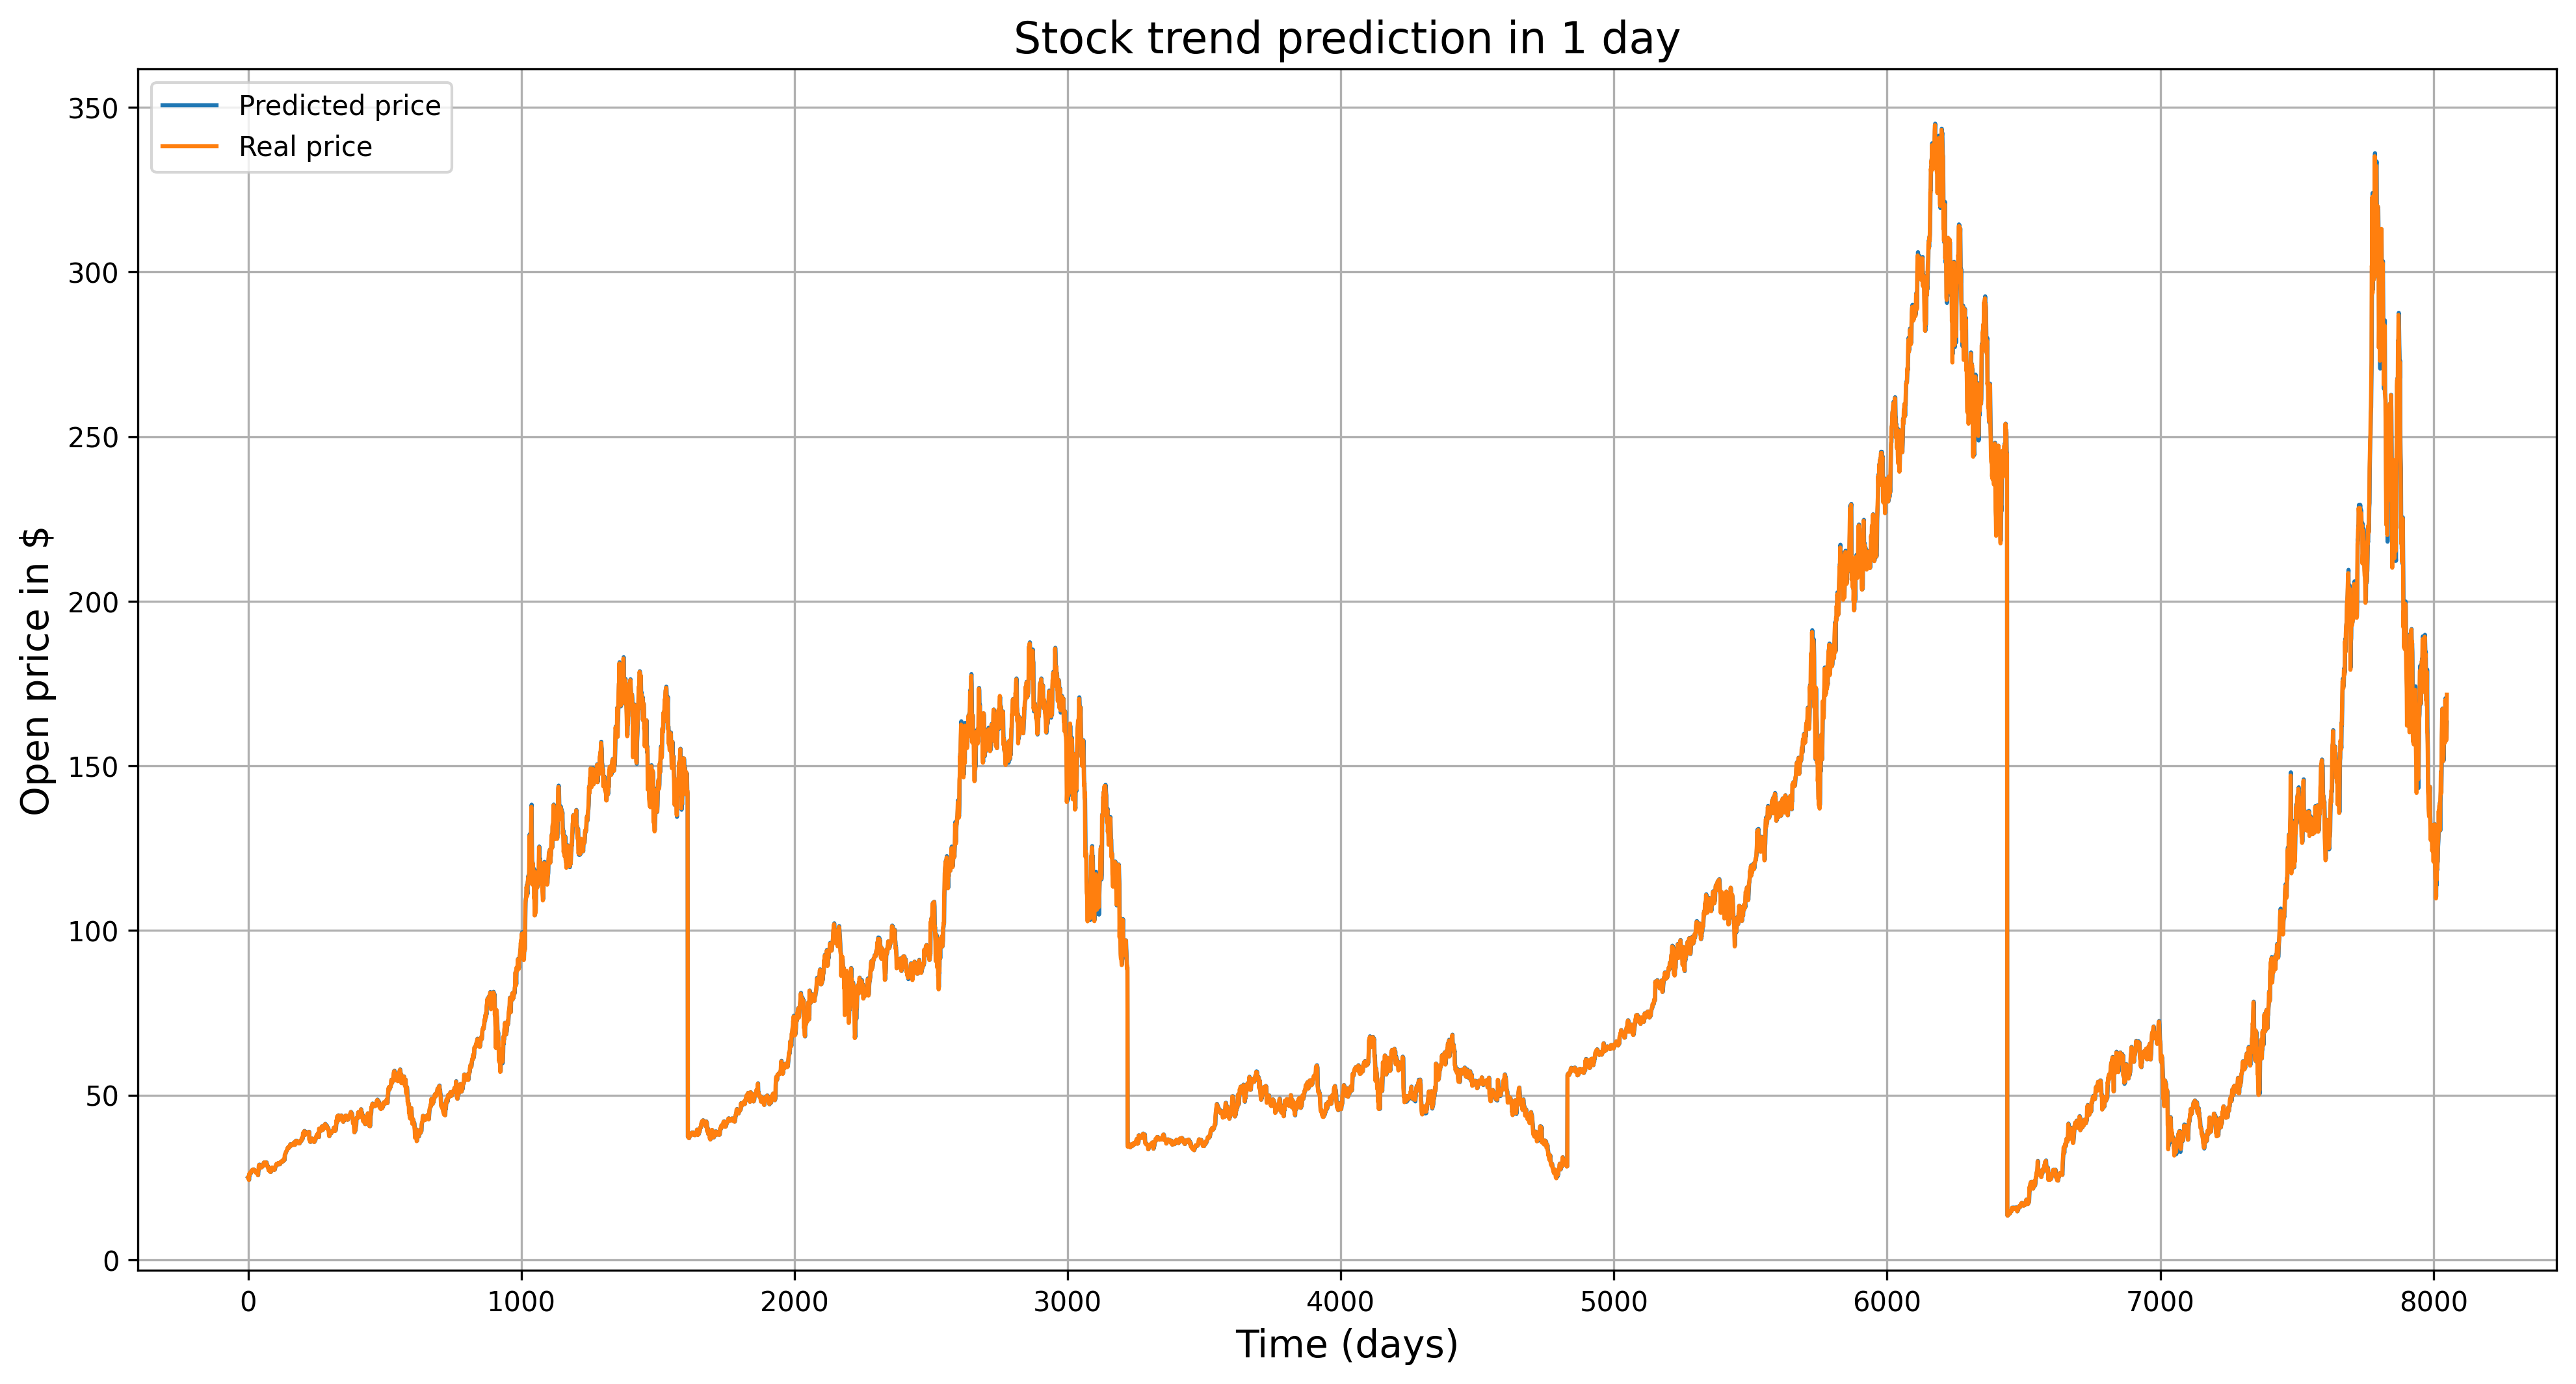

In [25]:
#conver the predicted result back to actual stock price
y_pred_denorm_nas = denorm(y_pred_norm_nas, X_test_nas)
visualize(y_pred_denorm_nas, y_test_nas, 1)

In [26]:
#compare some predicted values and actual values
for i in range(10):
    print("Predicted value: ", y_pred_denorm_nas[i], " Actual value: ", y_test_nas[i])


Predicted value:  [25.04908]  Actual value:  [24.95750046]
Predicted value:  [24.993145]  Actual value:  [24.81500053]
Predicted value:  [24.837019]  Actual value:  [24.5625]
Predicted value:  [24.589876]  Actual value:  [24.20499992]
Predicted value:  [24.23901]  Actual value:  [26.06749916]
Predicted value:  [26.005075]  Actual value:  [25.70750046]
Predicted value:  [25.6796]  Actual value:  [26.04750061]
Predicted value:  [26.062113]  Actual value:  [26.10250092]
Predicted value:  [26.146723]  Actual value:  [26.51250076]
Predicted value:  [26.549774]  Actual value:  [26.20249939]


In [27]:
#Let's see if the model tend to predict the price to be higher or lower than the actual value
num_samples = len(y_pred_denorm_nas)
num_higher = 0
num_lower = 0
for predicted, actual in zip(y_pred_denorm_nas, y_test_nas):
    if predicted[0] > actual[0]:
        num_higher += 1
    elif predicted[0] < actual[0]:
        num_lower += 1

percentage_higher = (num_higher / num_samples) * 100
percentage_lower = (num_lower / num_samples) * 100

print("Percentage of times predicted values are higher: {:.2f}%".format(percentage_higher))
print("Percentage of times predicted values are lower: {:.2f}%".format(percentage_lower))

Percentage of times predicted values are higher: 49.09%
Percentage of times predicted values are lower: 50.91%


## Train with GRU model

In [28]:
# Build the model architecture
gru_nas = tf.keras.Sequential()
gru_nas.add(GRU(32, return_sequences=True, input_shape=(window_size_1, 2), activation='relu'))
gru_nas.add(Dropout(0.2))
gru_nas.add(GRU(32, return_sequences=True))
gru_nas.add(Dropout(0.2))
gru_nas.add(Flatten())
gru_nas.add(Dense(100, activation='relu'))
gru_nas.add(Dense(1, activation='linear'))

In [29]:
#reshape data to fit with GRU model architecture
X_train_norm_nas_gru = np.reshape(X_train_norm_nas, (X_train_norm_nas.shape[0], X_train_norm_nas.shape[2], X_train_norm_nas.shape[1]))
X_val_norm_nas_gru = np.reshape(X_val_norm_nas, (X_val_norm_nas.shape[0], X_val_norm_nas.shape[2], X_val_norm_nas.shape[1]))
X_test_norm_nas_gru = np.reshape(X_test_norm_nas, (X_test_norm_nas.shape[0], X_test_norm_nas.shape[2], X_test_norm_nas.shape[1]))

#compile the model
gru_nas.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [30]:
#Apply cross validation
from sklearn.model_selection import TimeSeriesSplit

# Define the number of folds for cross-validation
n_splits = 5

# Define the time series split object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop over the folds
for i, (train_index, val_index) in enumerate(tscv.split(X_train_norm_nas_gru)):
    # Split the training data into training and validation sets based on the indices
    X_train_fold, X_val_fold = X_train_norm_nas_gru[train_index], X_train_norm_nas_gru[val_index]
    y_train_fold, y_val_fold = y_train_norm_nas[train_index], y_train_norm_nas[val_index]
    
    # Train and evaluate the model on this fold
    gru_nas_history = gru_nas.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=5, batch_size=32, callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    score = gru_nas.evaluate(X_test_norm_nas_gru, y_test_norm_nas)
    
    # Print the results for this fold
    print("Fold {} - Score: {}".format(i, score))


Epoch 1/5
143/143 [==============================] - 23s 122ms/step - loss: 0.1725 - mse: 0.1725 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/5
143/143 [==============================] - 17s 118ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 3/5
143/143 [==============================] - 17s 117ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 4/5
143/143 [==============================] - 17s 116ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 5/5
252/252 [==============================] - 5s 21ms/step - loss: 0.0175 - mse: 0.0175
Fold 0 - Score: [0.017503192648291588, 0.017503192648291588]
Epoch 1/5
285/285 [==============================] - 31s 108ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 2/5
285/285 [==============================] - 34s 118ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 3/5
285/285 [=====================

In [31]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
# Get prediction on the test data
y_pred_norm_nas_gru = gru_nas.predict(X_test_norm_nas_gru)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_nas_gru, y_test_norm_nas))

252/252 [==============================] - 5s 19ms/step
MSE on the test set:  0.008040701893462109


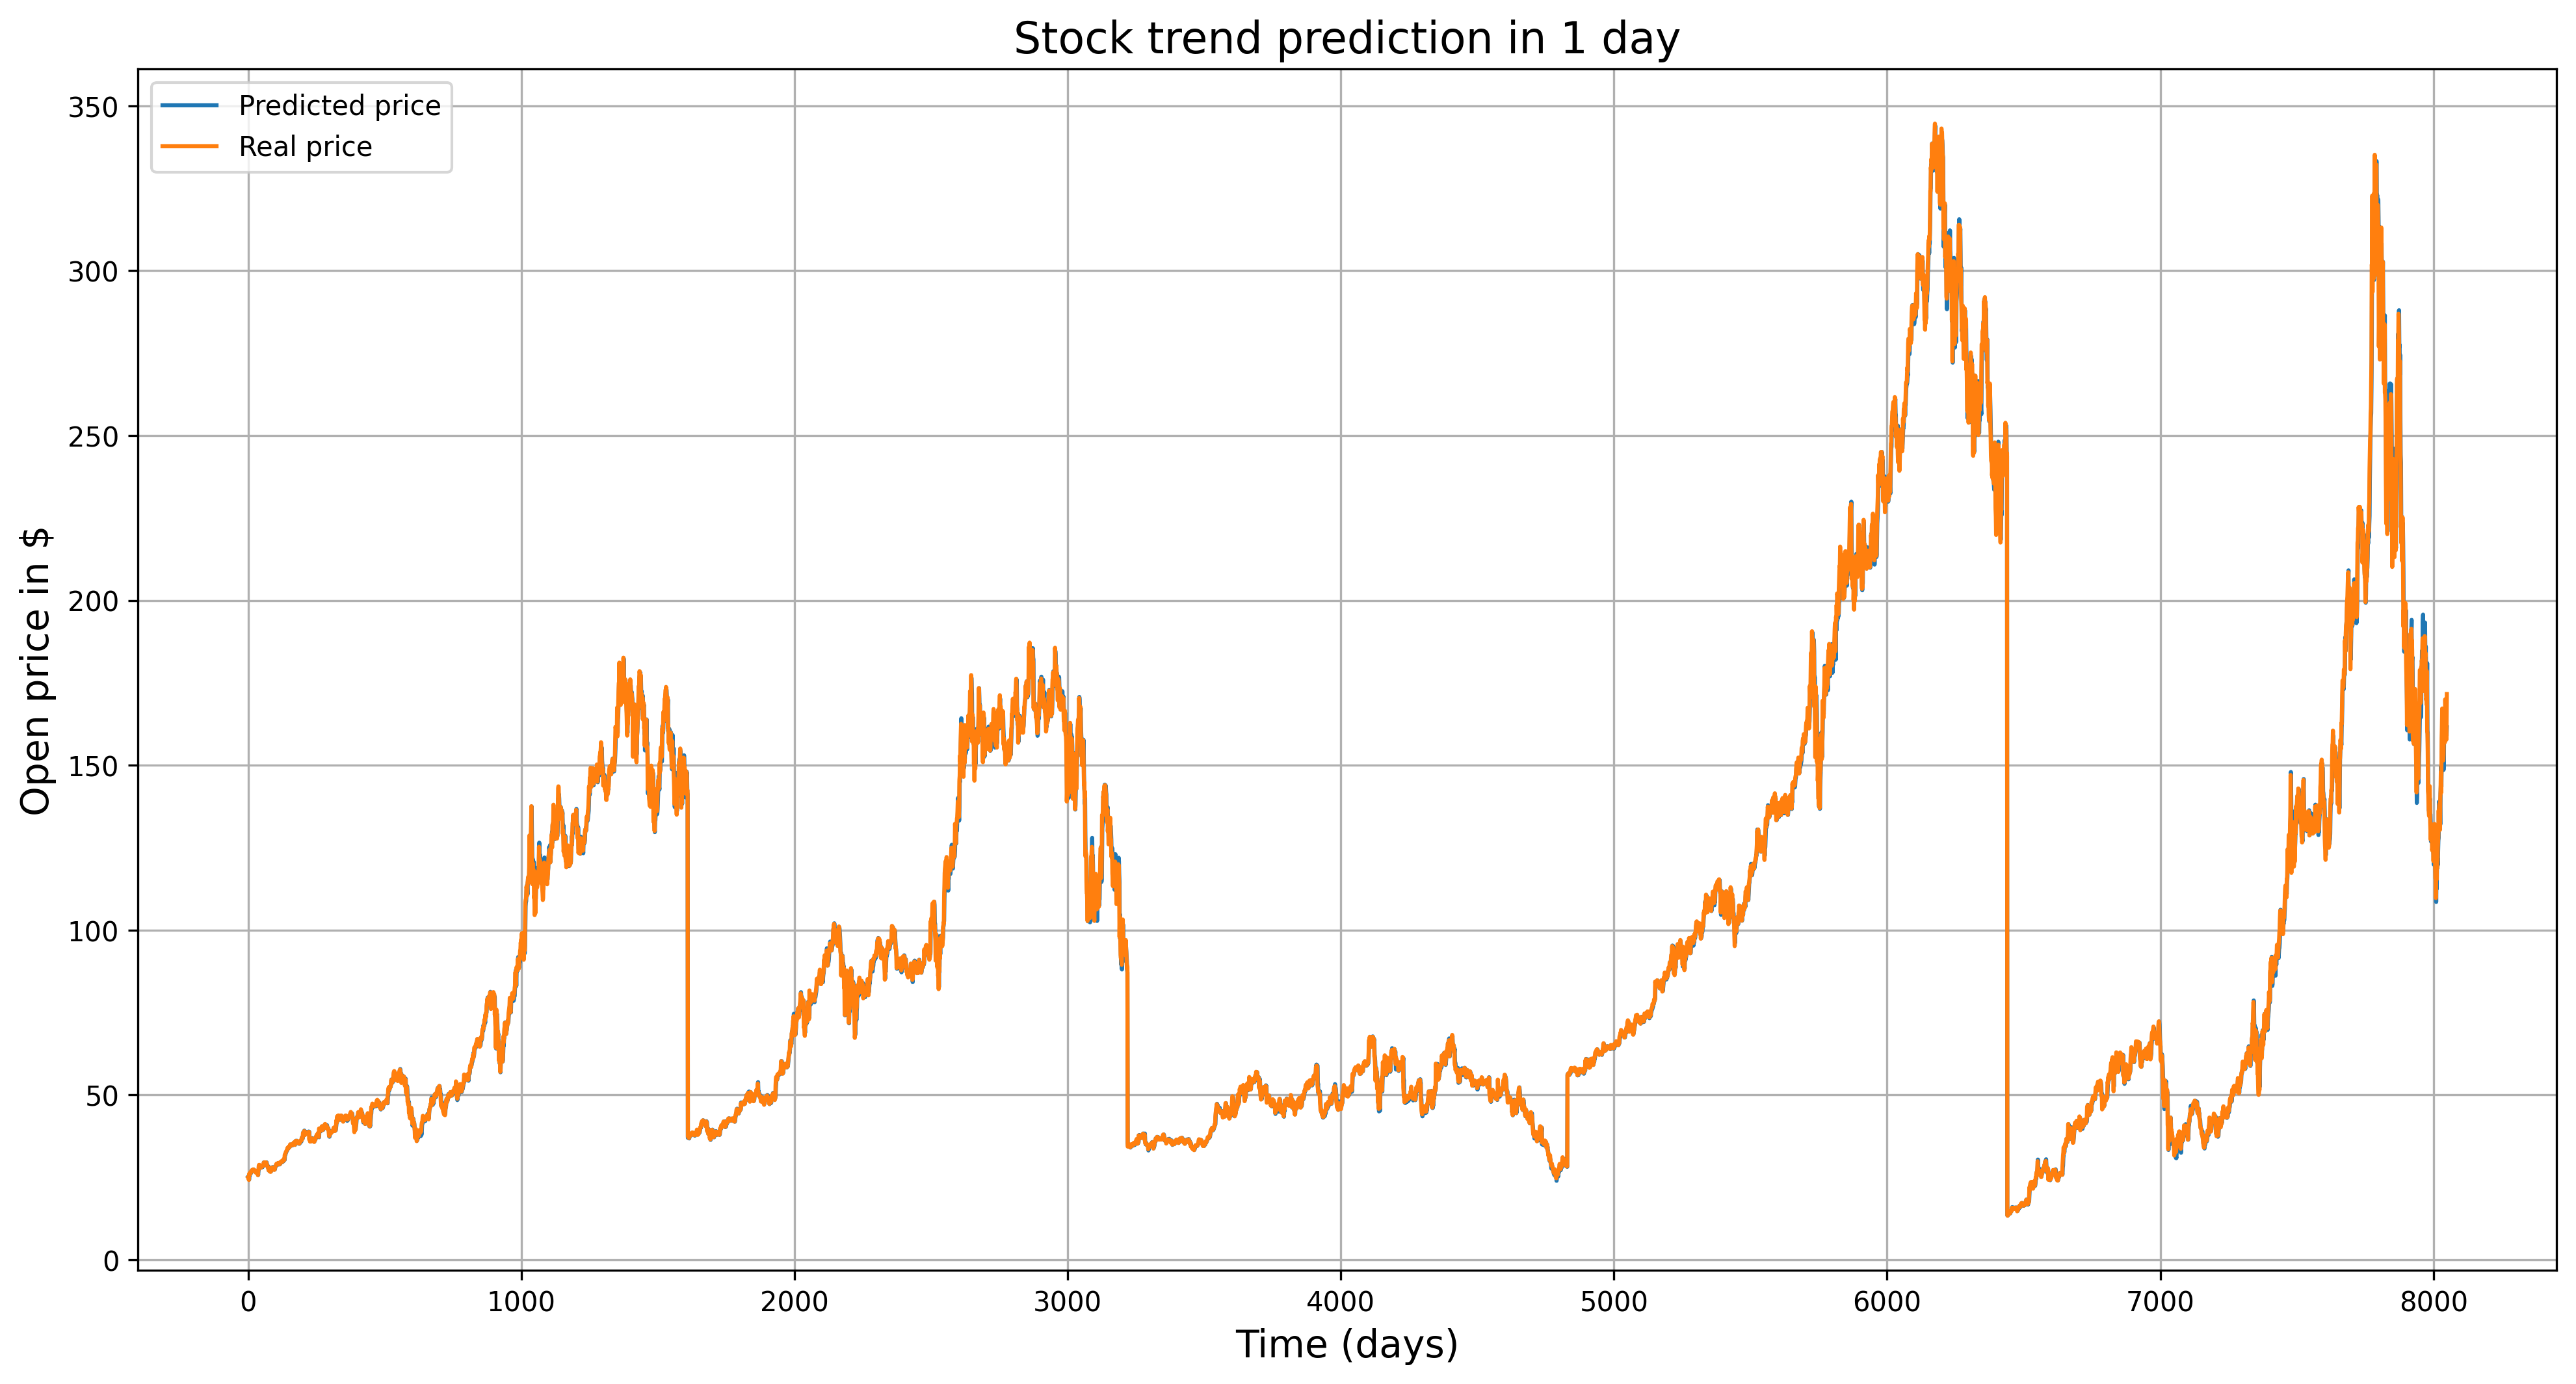

In [32]:
#conver the predicted result back to actual stock price
y_pred_denorm_nas_gru = denorm(y_pred_norm_nas_gru, X_test_nas)
visualize(y_pred_denorm_nas_gru, y_test_nas, 1)

In [33]:
y_pred_norm_nas_gru[0]

array([0.4868185], dtype=float32)

In [34]:
#compare some predicted values and actual values
for i in range(5):
    print("Predicted value: ", y_pred_denorm_nas_gru[i], " Actual value: ", y_test_nas[i])


Predicted value:  [25.19089]  Actual value:  [24.95750046]
Predicted value:  [25.12984]  Actual value:  [24.81500053]
Predicted value:  [24.973557]  Actual value:  [24.5625]
Predicted value:  [24.710936]  Actual value:  [24.20499992]
Predicted value:  [24.288605]  Actual value:  [26.06749916]


In [35]:
#Let's see if the model tend to predict the price to be higher or lower than the actual value
num_samples = len(y_pred_denorm_nas_gru)
num_higher = 0
num_lower = 0
for predicted, actual in zip(y_pred_denorm_nas_gru, y_test_nas):
    if predicted[0] > actual[0]:
        num_higher += 1
    elif predicted[0] < actual[0]:
        num_lower += 1

percentage_higher = (num_higher / num_samples) * 100
percentage_lower = (num_lower / num_samples) * 100

print("Percentage of times predicted values are higher: {:.2f}%".format(percentage_higher))
print("Percentage of times predicted values are lower: {:.2f}%".format(percentage_lower))

Percentage of times predicted values are higher: 43.23%
Percentage of times predicted values are lower: 56.77%


## Test on different companies

Test the model performance on different companies that are not used in the training phase

### Same industry

In [36]:
#load the data and split feature and label
same_industry_nas = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/nasdaq/same industry')
X_same_nas, y_same_nas = prep_dataset(same_industry_nas, window_size_1, time_1, label_range_1, 2, 3)

In [37]:
y_same_nas[0]

array([149.16000366])

In [38]:
# Convert from lists to Numpy arrays for reshaping purpose
X_same_nas = np.array(X_same_nas)
y_same_nas = np.array(y_same_nas)
# Reshape the numpy array to fit the neural network input shape requirement
X_same_nas = X_same_nas.reshape(X_same_nas.shape[0], 2, window_size_1, 1)

In [39]:
X_same_nas.shape

(1358, 2, 90, 1)

In [40]:
# MinMax normalize data: x=(x-min(x)/(max(x)-min(x))
X_same_norm_nas, y_same_norm_nas = normalize(X_same_nas, y_same_nas)

In [41]:
# Get prediction on the test data
y_pred_same_nas = conv_nas.predict(X_same_norm_nas)
print("MSE on the test set: ", mean_squared_error(y_pred_same_nas, y_same_norm_nas))

43/43 [==============================] - 0s 7ms/step
MSE on the test set:  0.007884971383386296


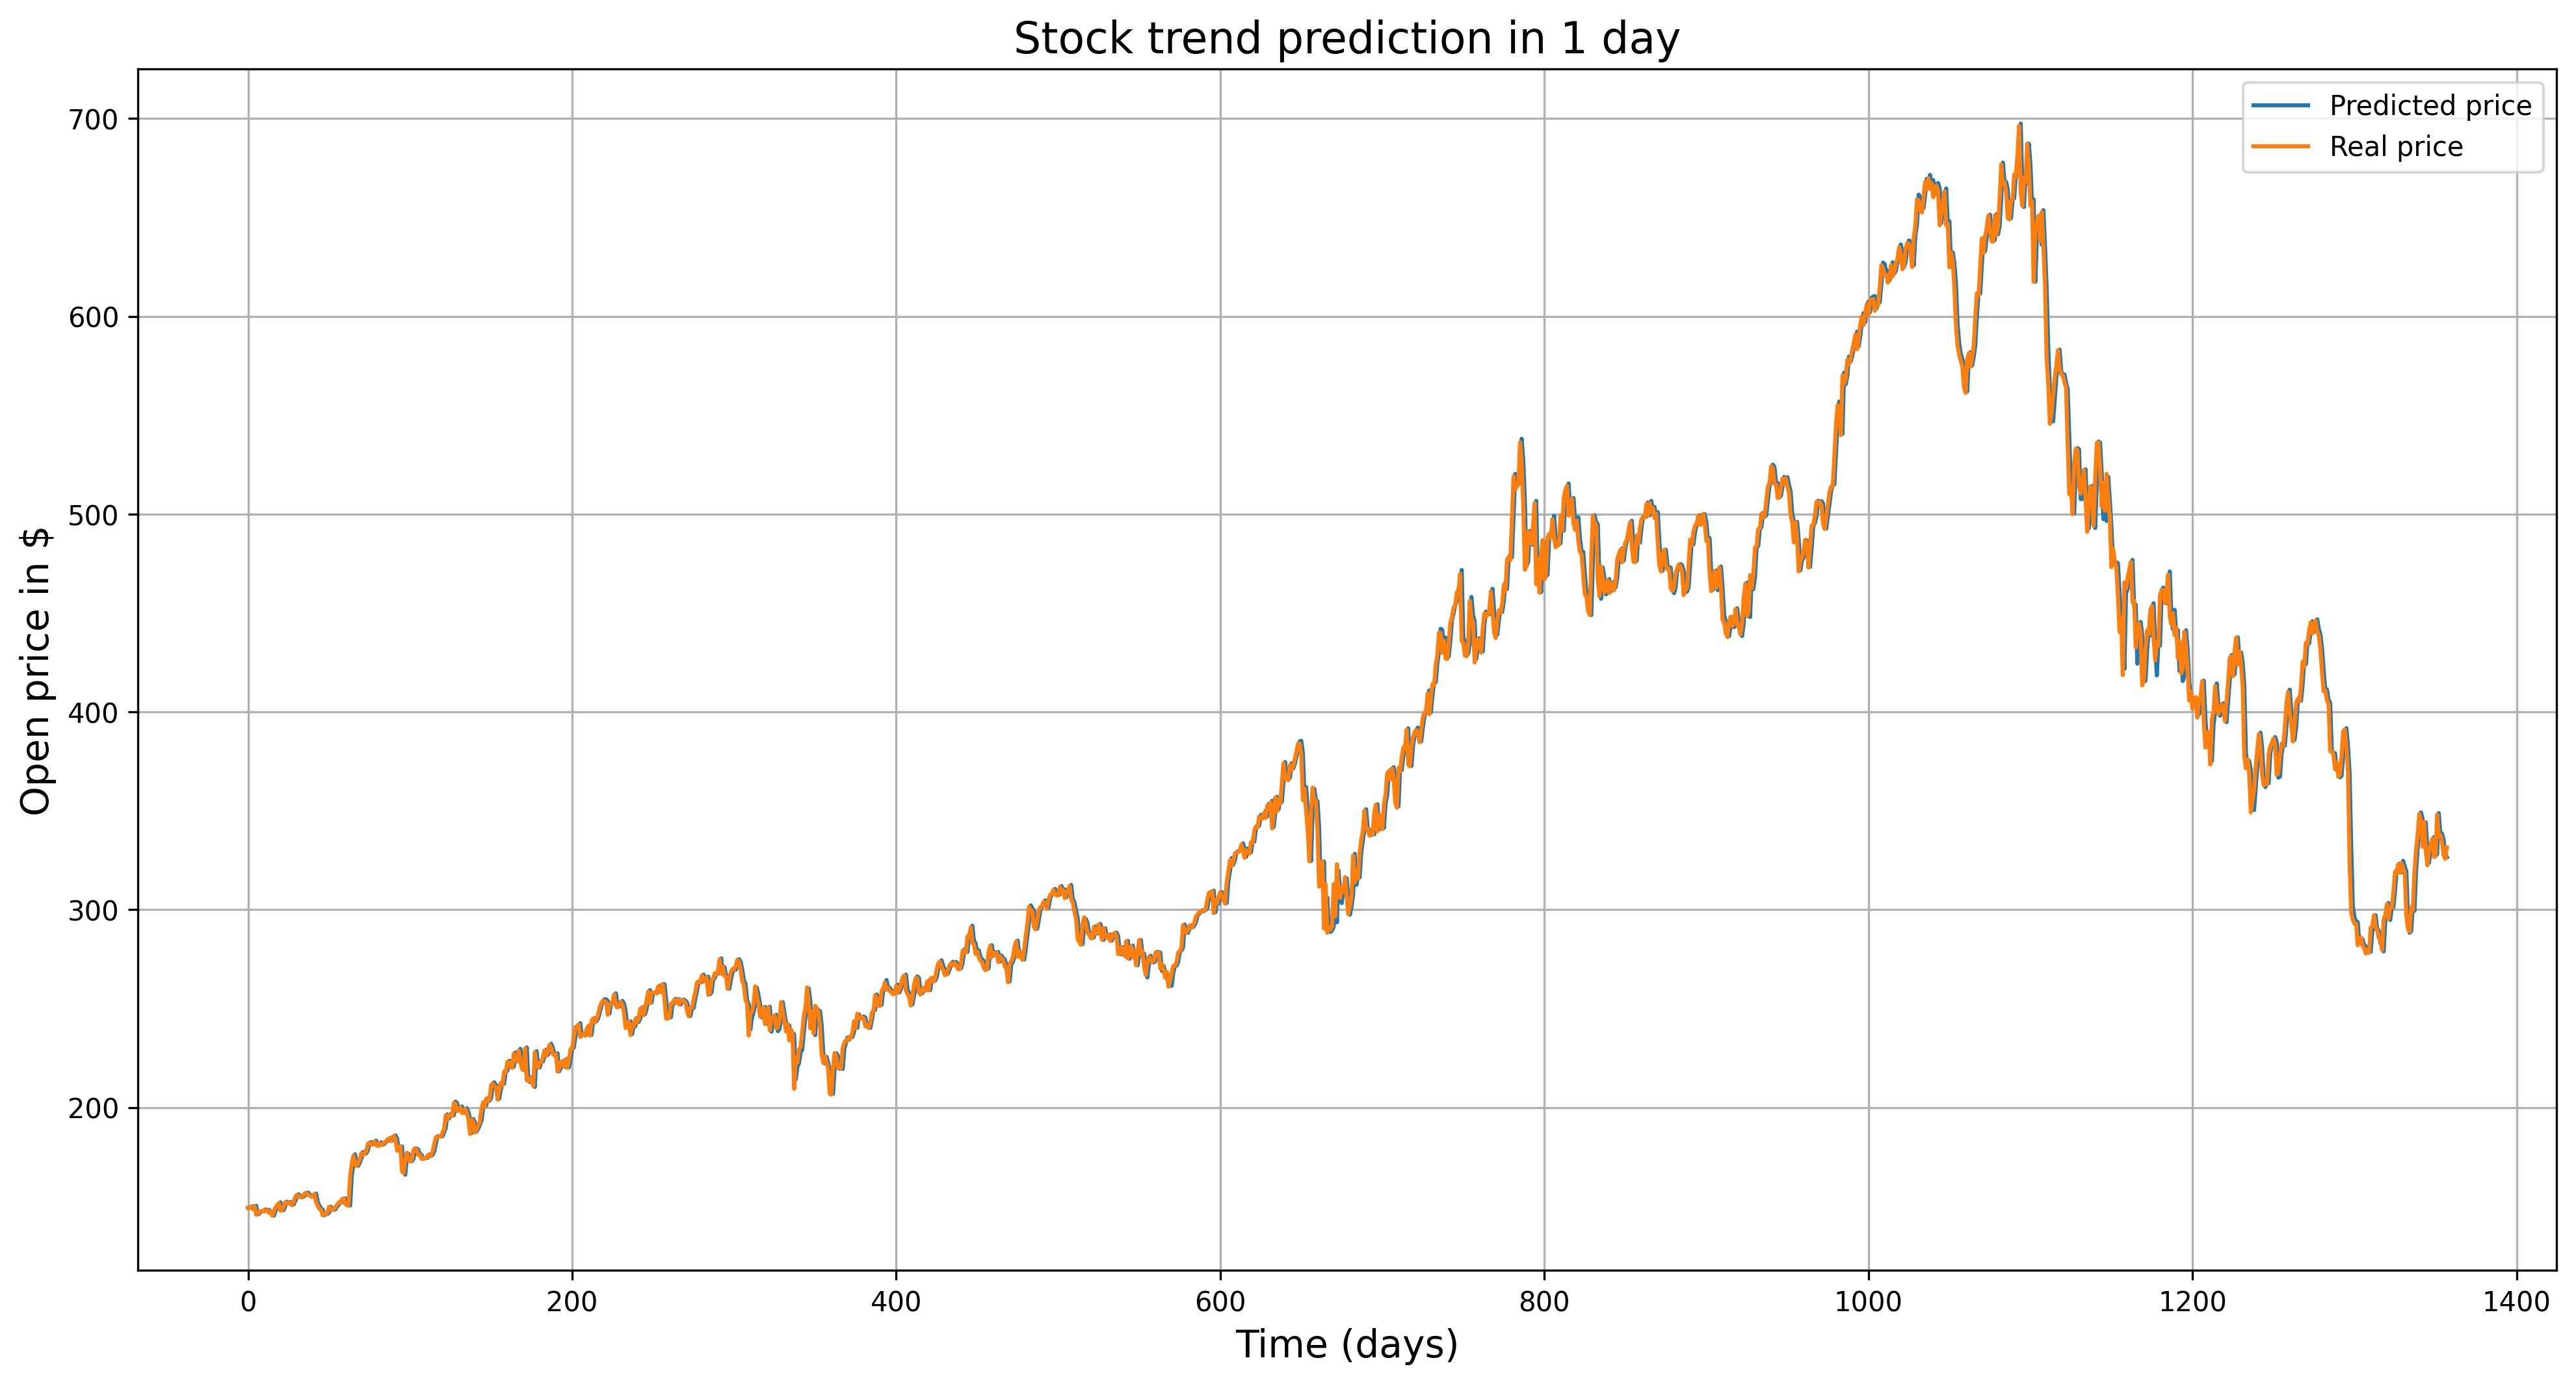

In [42]:
#conver the predicted result back to actual stock price
y_pred_same_denorm_nas = denorm(y_pred_same_nas, X_same_nas)
visualize(y_pred_same_denorm_nas, y_same_nas, 1)

### different industry

In [43]:
#get the data and split feature and label
dif_industry_nas = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/nasdaq/different industry')
X_dif_nas, y_dif_nas = prep_dataset(dif_industry_nas, window_size_1, time_1, label_range_1, 2, 3)

In [44]:
y_dif_nas[0]

array([150.94000244])

In [45]:
# Convert from lists to Numpy arrays for reshaping purpose
X_dif_nas = np.array(X_dif_nas)
y_dif_nas = np.array(y_dif_nas)
# Reshape the numpy array to fit the neural network input shape requirement
X_dif_nas = X_dif_nas.reshape(X_dif_nas.shape[0], 2, window_size_1, 1)

In [46]:
X_dif_nas.shape

(1358, 2, 90, 1)

In [47]:
# MinMax normalize data: x=(x-min(x)/(max(x)-min(x))
X_dif_norm_nas, y_dif_norm_nas = normalize(X_dif_nas, y_dif_nas)

In [48]:
# Get prediction on the test data
y_pred_dif_nas = conv_nas.predict(X_dif_norm_nas)
print("MSE on the test set: ", mean_squared_error(y_pred_dif_nas, y_dif_norm_nas))

43/43 [==============================] - 1s 13ms/step
MSE on the test set:  0.006582844825728563


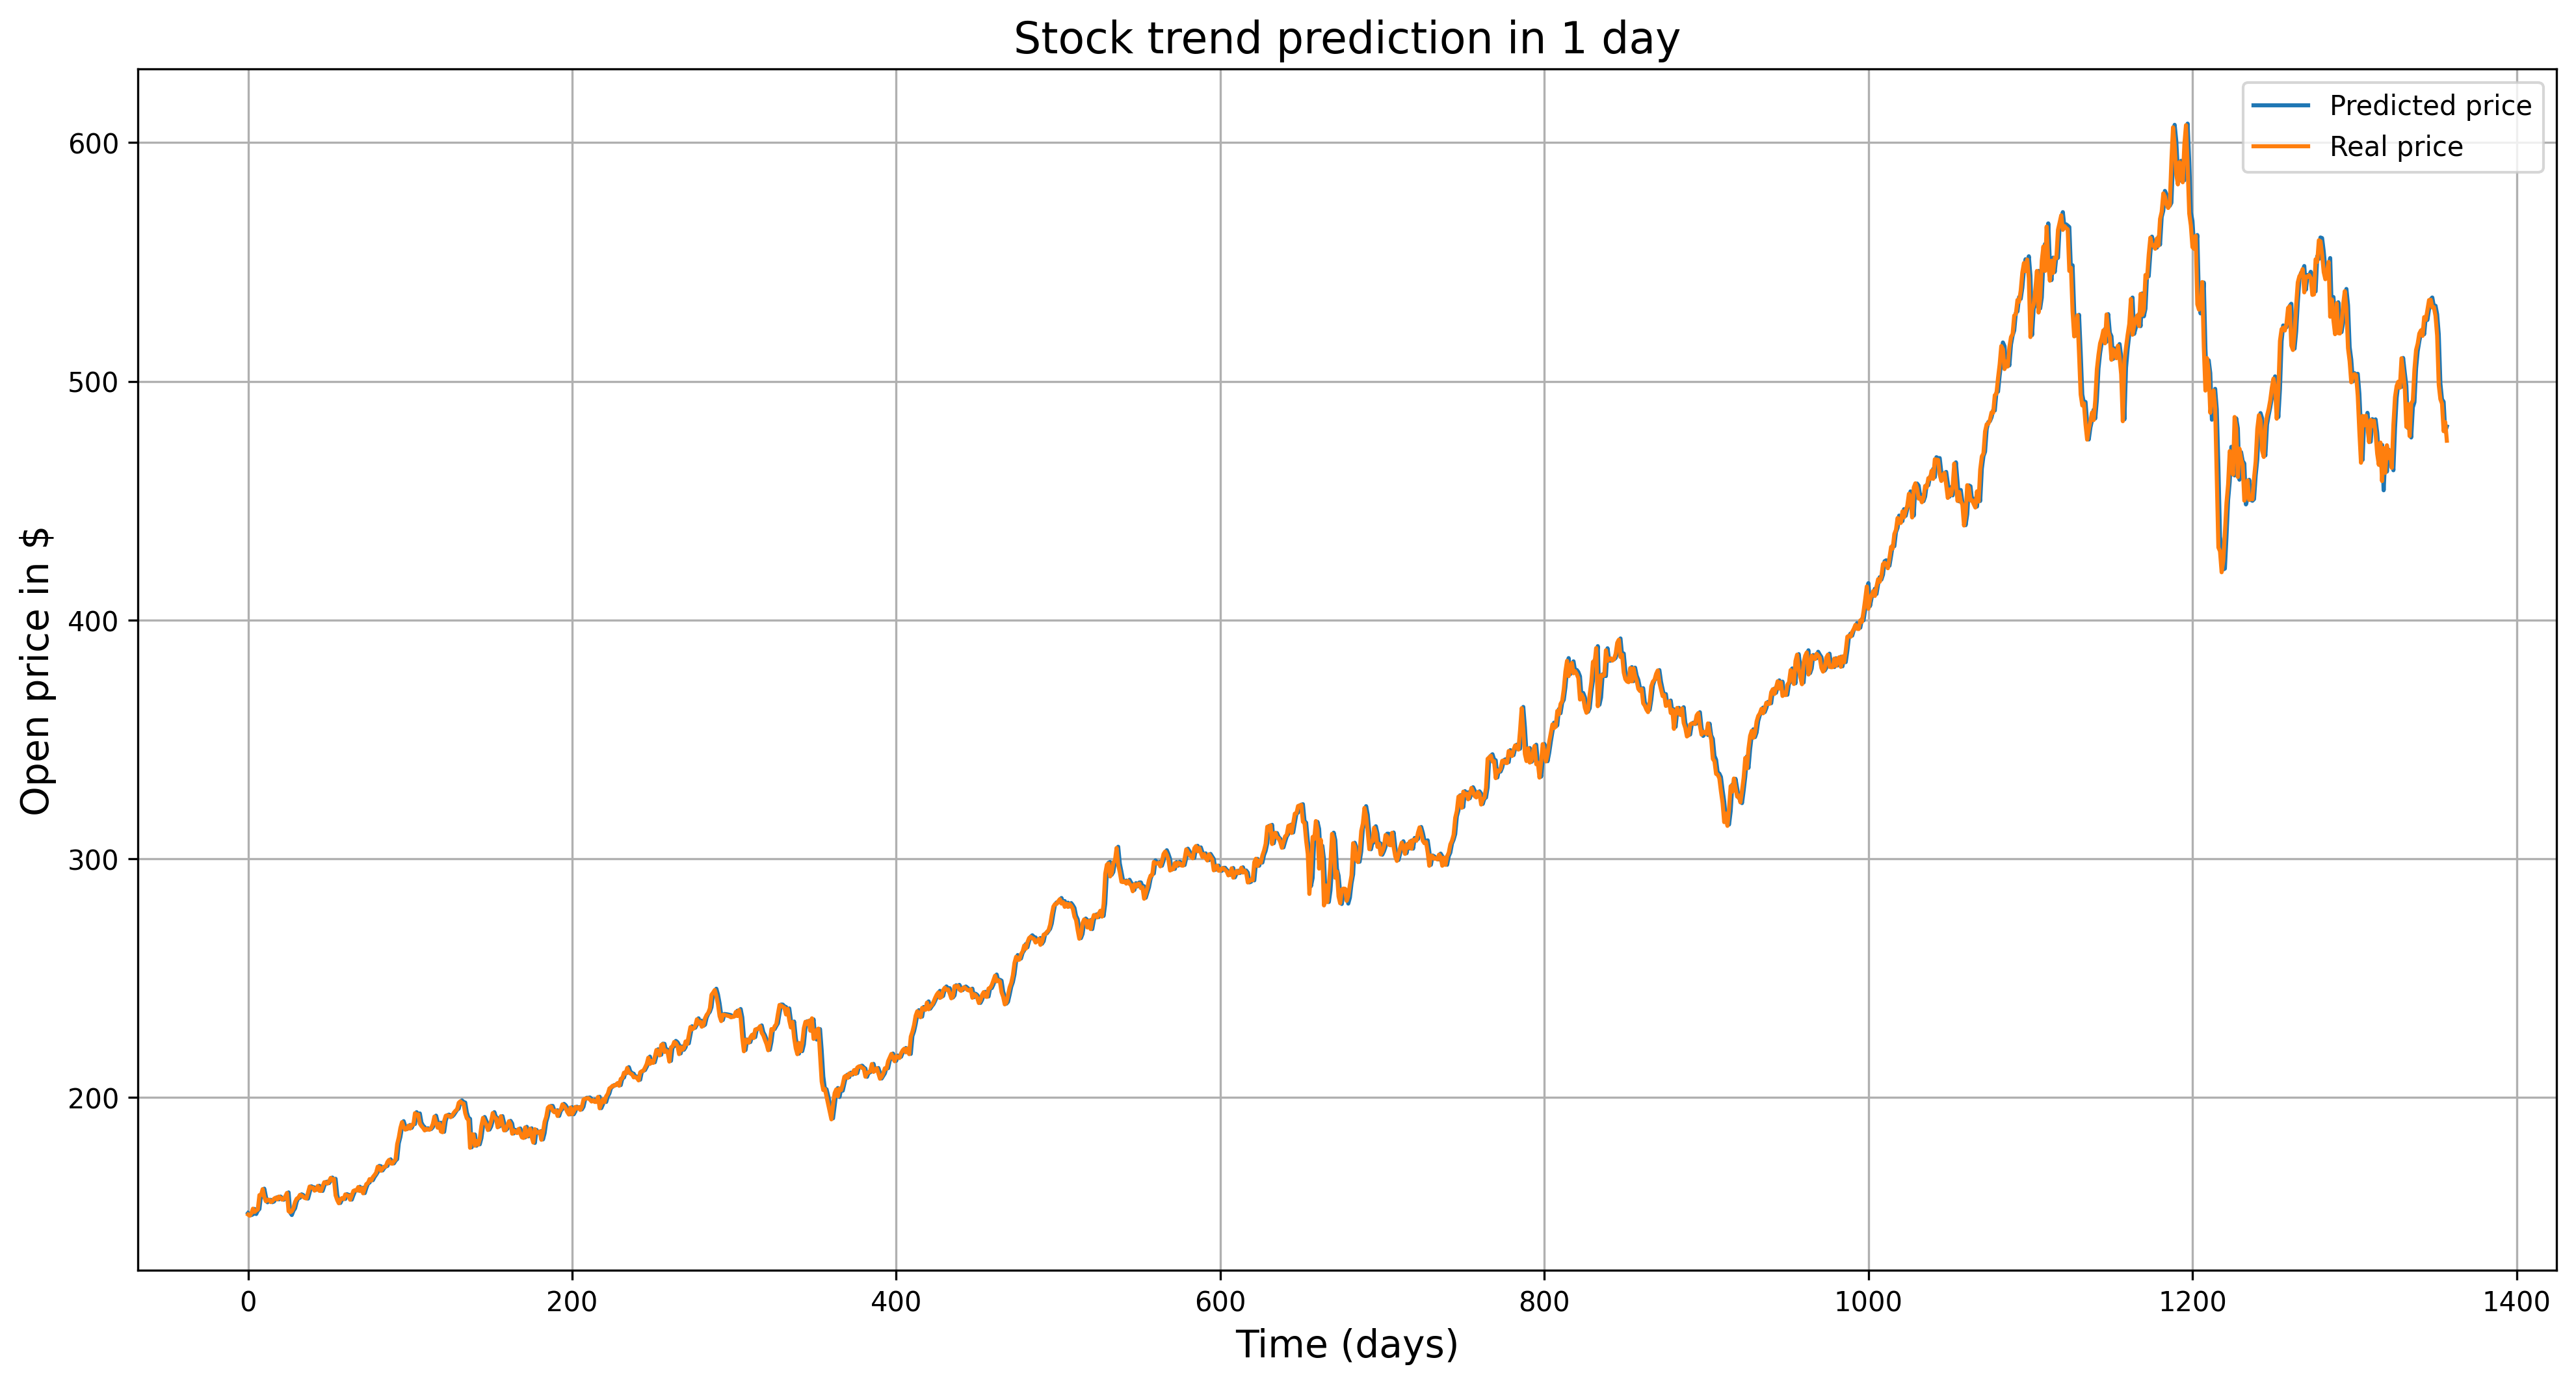

In [49]:
#conver the predicted result back to actual stock price
y_pred_dif_denorm_nas = denorm(y_pred_dif_nas, X_dif_nas)
visualize(y_pred_dif_denorm_nas, y_dif_nas, 1)

# Task 2 - VN

## Prepare training and testing data

In [50]:
open_index_vn = 2
volume_index_vn = 6

#split features and labels for training set
train_path_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/train data')
X_train_vn, y_train_vn = prep_dataset(train_path_vn, window_size_1, time_1, label_range_1, open_index_vn, volume_index_vn)

In [51]:
#split features and labels for testing set
test_path_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/test data')
X_test_vn, y_test_vn = prep_dataset(test_path_vn, window_size_1, time_1, label_range_1, open_index_vn, volume_index_vn)

In [52]:
#split train and validation set
X_train_vn, X_val_vn, y_train_vn, y_val_vn = train_test_split(X_train_vn, y_train_vn, test_size=0.2, shuffle=False)

In [53]:
#reshape to fit the neural network input shape requirement
X_train_vn, y_train_vn, X_test_vn, y_test_vn, X_val_vn, y_val_vn = reshape_1d(X_train_vn, y_train_vn, X_test_vn, y_test_vn, X_val_vn, y_val_vn, window_size_1)

Shape of training set:  (13464, 2, 90, 1)
Shape of validation set:  (3367, 2, 90, 1)
Shape of test set:  (6975, 2, 90, 1)


In [54]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm_vn, y_train_norm_vn = normalize(X_train_vn, y_train_vn)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm_vn, y_val_norm_vn = normalize(X_val_vn, y_val_vn)

# MinMax normalize the testing data: x=(x-min(x)/(max(x)-min(x))
X_test_norm_vn, y_test_norm_vn = normalize(X_test_vn, y_test_vn)

## Train with Conv1d Model

In [55]:
# Build the model architecture
vn_model = tf.keras.Sequential()
vn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(2, window_size_1, 1), padding='same'))
vn_model.add(MaxPooling2D(pool_size=(1,2)))
vn_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
vn_model.add(MaxPooling2D(1, 2))
vn_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
vn_model.add(MaxPooling2D(1, 2))
vn_model.add(Flatten())
vn_model.add(Dense(100, activation='relu'))
vn_model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

In [56]:
# Compile and train the model with Mean Squared Error loss function
vn_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
vn_history = vn_model.fit(X_train_norm_vn, y_train_norm_vn, validation_data=(X_val_norm_vn, y_val_norm_vn), epochs=20, batch_size=512, callbacks=[early_stopping])

Epoch 1/20
27/27 [==============================] - 11s 343ms/step - loss: 0.1832 - mse: 0.1832 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 2/20
27/27 [==============================] - 11s 407ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 3/20
27/27 [==============================] - 11s 410ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/20
27/27 [==============================] - 10s 355ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5/20
27/27 [==============================] - 10s 370ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6/20
27/27 [==============================] - 11s 409ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 7/20
27/27 [==============================] - 11s 398ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0088 - val_mse: 0.0088


## Test the model

In [57]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
# Get prediction on the test data
y_pred_norm_vn = vn_model.predict(X_test_norm_vn)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_vn, y_test_norm_vn))

218/218 [==============================] - 2s 10ms/step
MSE on the test set:  0.01011625255701419


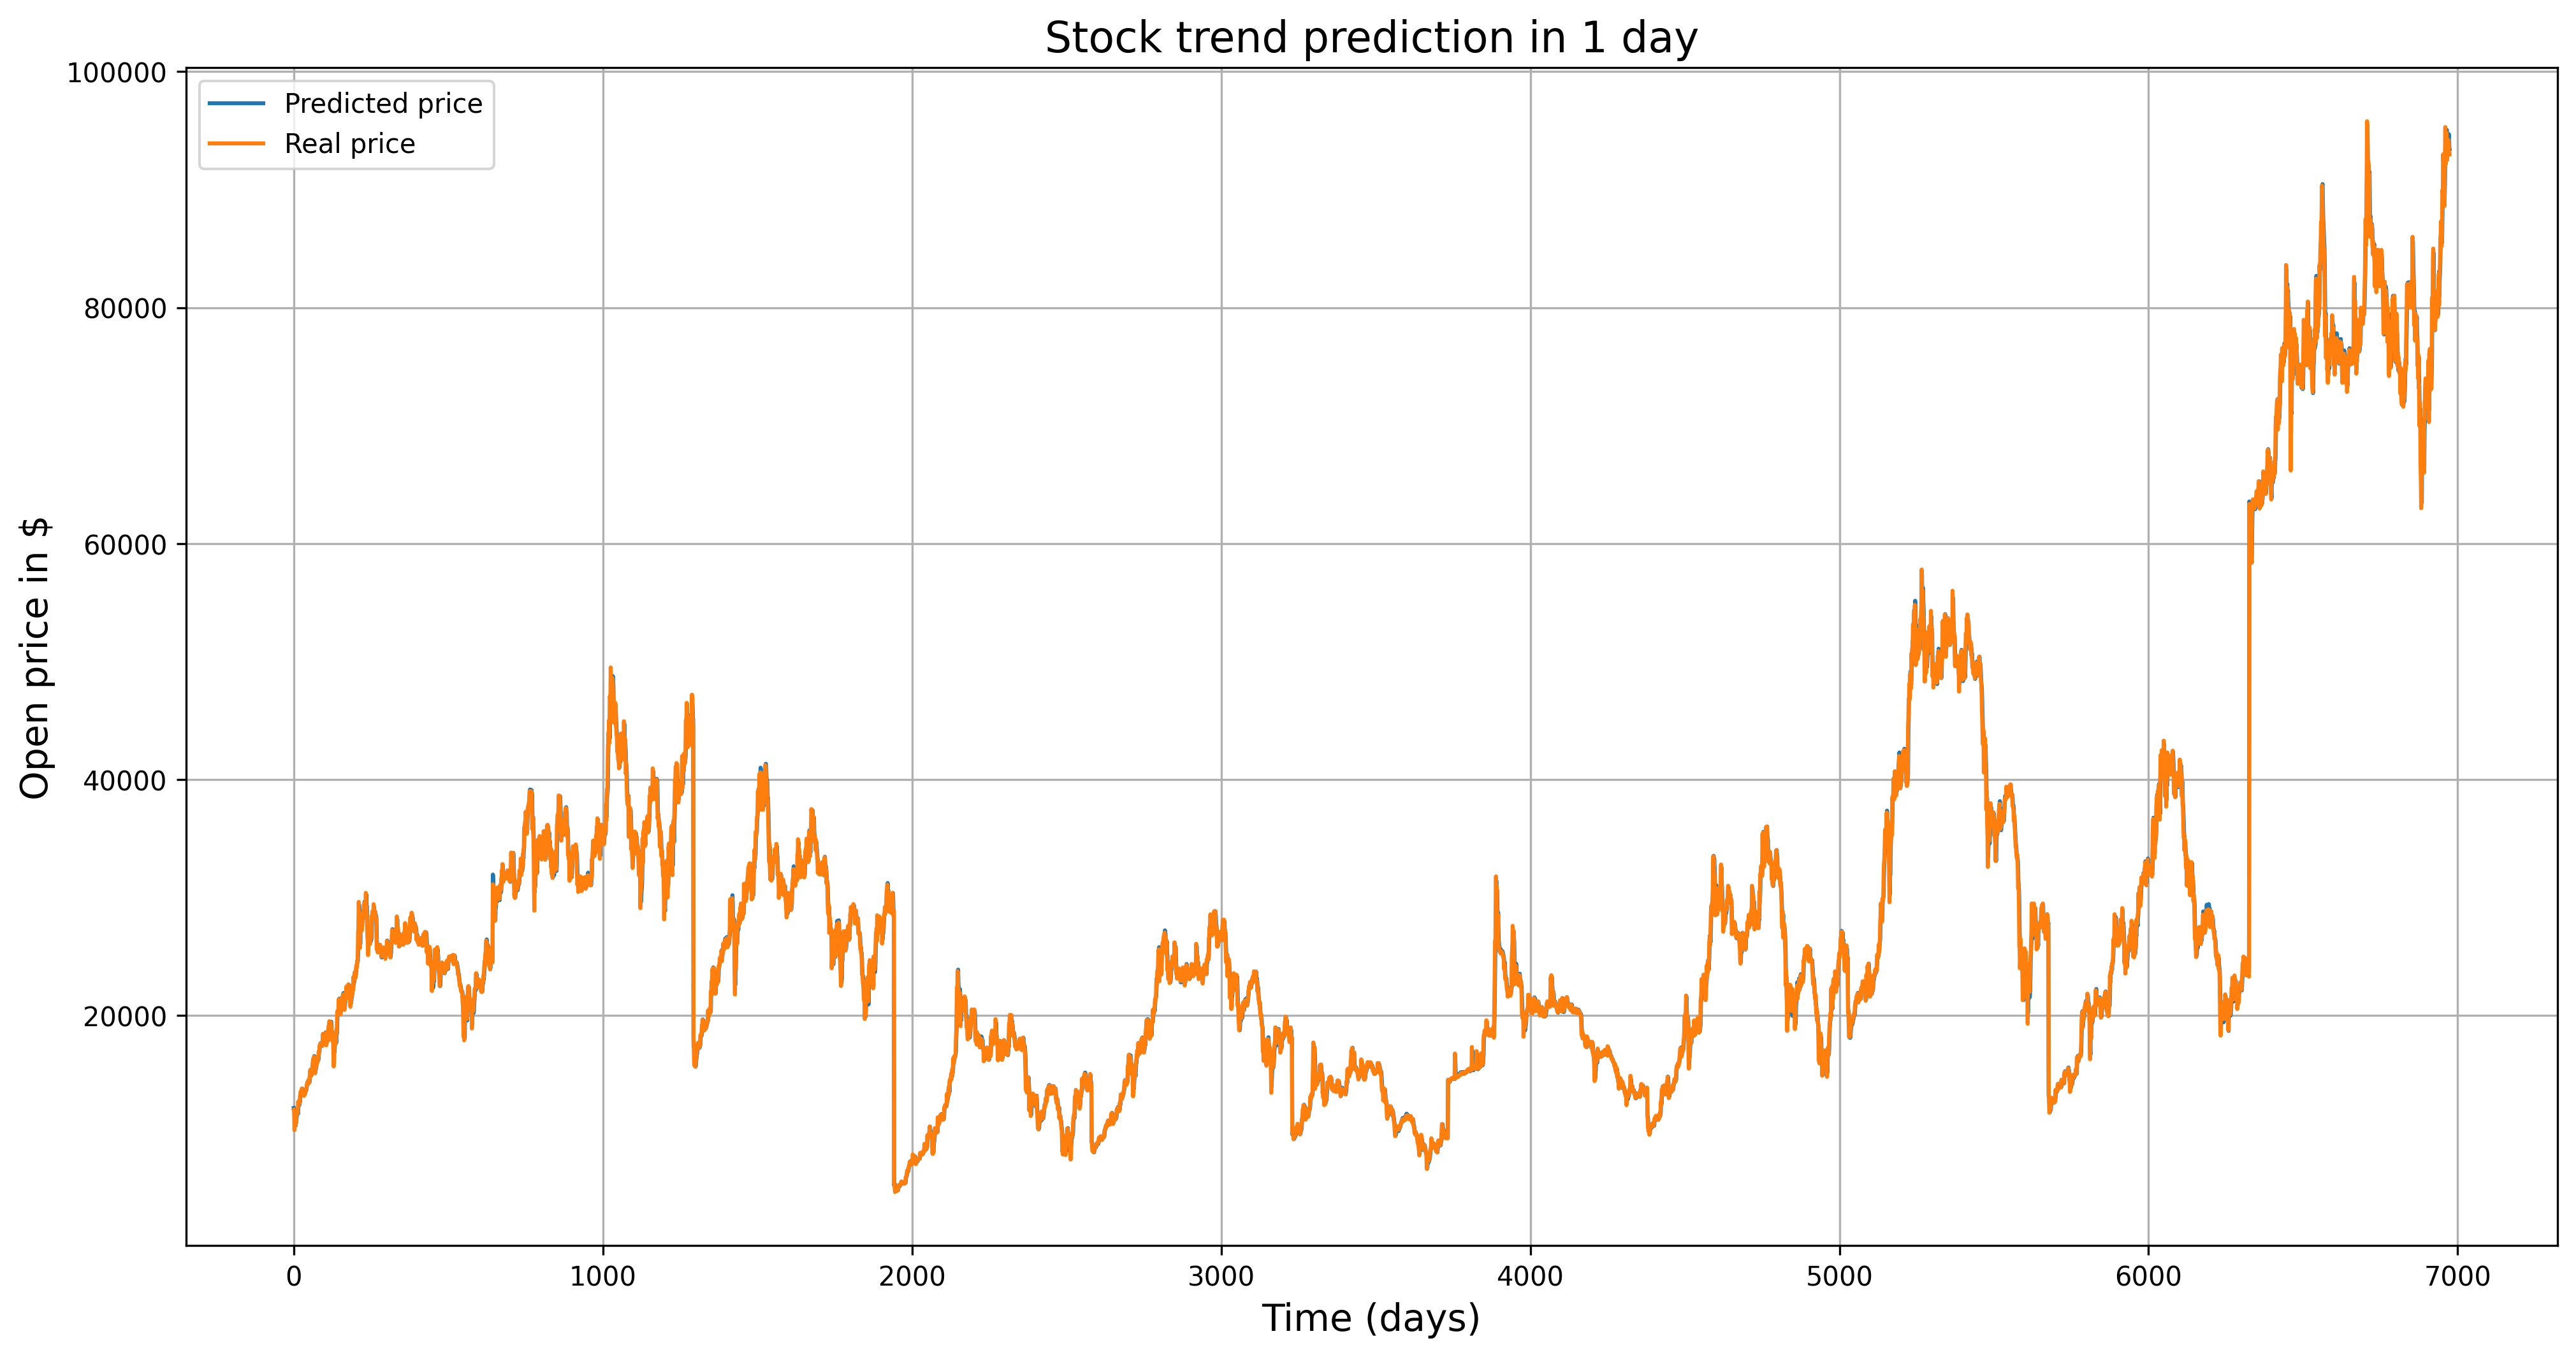

In [58]:
#conver the predicted result back to actual stock price
y_pred_denorm_vn = denorm(y_pred_norm_vn, X_test_vn)
visualize(y_pred_denorm_vn, y_test_vn, 1)

In [59]:
#compare some predicted values and actual values
for i in range(10):
    print("Predicted value: ", y_pred_denorm_vn[i], " Actual value: ", y_test_vn[i])

Predicted value:  [12167.035]  Actual value:  [12012.]
Predicted value:  [12063.697]  Actual value:  [11963.]
Predicted value:  [12004.238]  Actual value:  [10289.]
Predicted value:  [10811.531]  Actual value:  [10732.]
Predicted value:  [10673.593]  Actual value:  [11175.]
Predicted value:  [11122.027]  Actual value:  [10683.]
Predicted value:  [10668.858]  Actual value:  [11175.]
Predicted value:  [11046.496]  Actual value:  [10880.]
Predicted value:  [10954.846]  Actual value:  [11470.]
Predicted value:  [11353.232]  Actual value:  [11766.]


In [60]:
#Let's see if the model tend to predict the price to be higher or lower than the actual value
num_samples = len(y_pred_denorm_vn)
num_higher = 0
num_lower = 0
for predicted, actual in zip(y_pred_denorm_vn, y_test_vn):
    if predicted[0] > actual[0]:
        num_higher += 1
    elif predicted[0] < actual[0]:
        num_lower += 1

percentage_higher = (num_higher / num_samples) * 100
percentage_lower = (num_lower / num_samples) * 100

print("Percentage of times predicted values are higher: {:.2f}%".format(percentage_higher))
print("Percentage of times predicted values are lower: {:.2f}%".format(percentage_lower))

Percentage of times predicted values are higher: 50.97%
Percentage of times predicted values are lower: 49.03%


## Test on different companies

Test the model performance on different companies that are not used in the training phase

### Same industry

In [61]:
same_industry_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/same industry')
X_same_vn, y_same_vn = prep_dataset(same_industry_vn, window_size_1, time_1, label_range_1, 1, 5)

In [62]:
# Convert from lists to Numpy arrays for reshaping purpose
X_same_vn = np.array(X_same_vn)
y_same_vn = np.array(y_same_vn)
# Reshape the numpy array to fit the neural network input shape requirement
X_same_vn = X_same_vn.reshape(X_same_vn.shape[0], 2, window_size_1, 1)

In [63]:
X_same_vn.shape

(392, 2, 90, 1)

In [64]:
y_same_vn[0]

array([26490.])

In [65]:
# MinMax normalize data: x=(x-min(x)/(max(x)-min(x))
X_same_norm_vn, y_same_norm_vn = normalize(X_same_vn, y_same_vn)

In [66]:
# Get prediction on the test data
y_pred_same_vn = vn_model.predict(X_same_norm_vn)
print("MSE on the test set: ", mean_squared_error(y_pred_same_vn, y_same_norm_vn))

13/13 [==============================] - 0s 8ms/step
MSE on the test set:  0.0074212229140540225


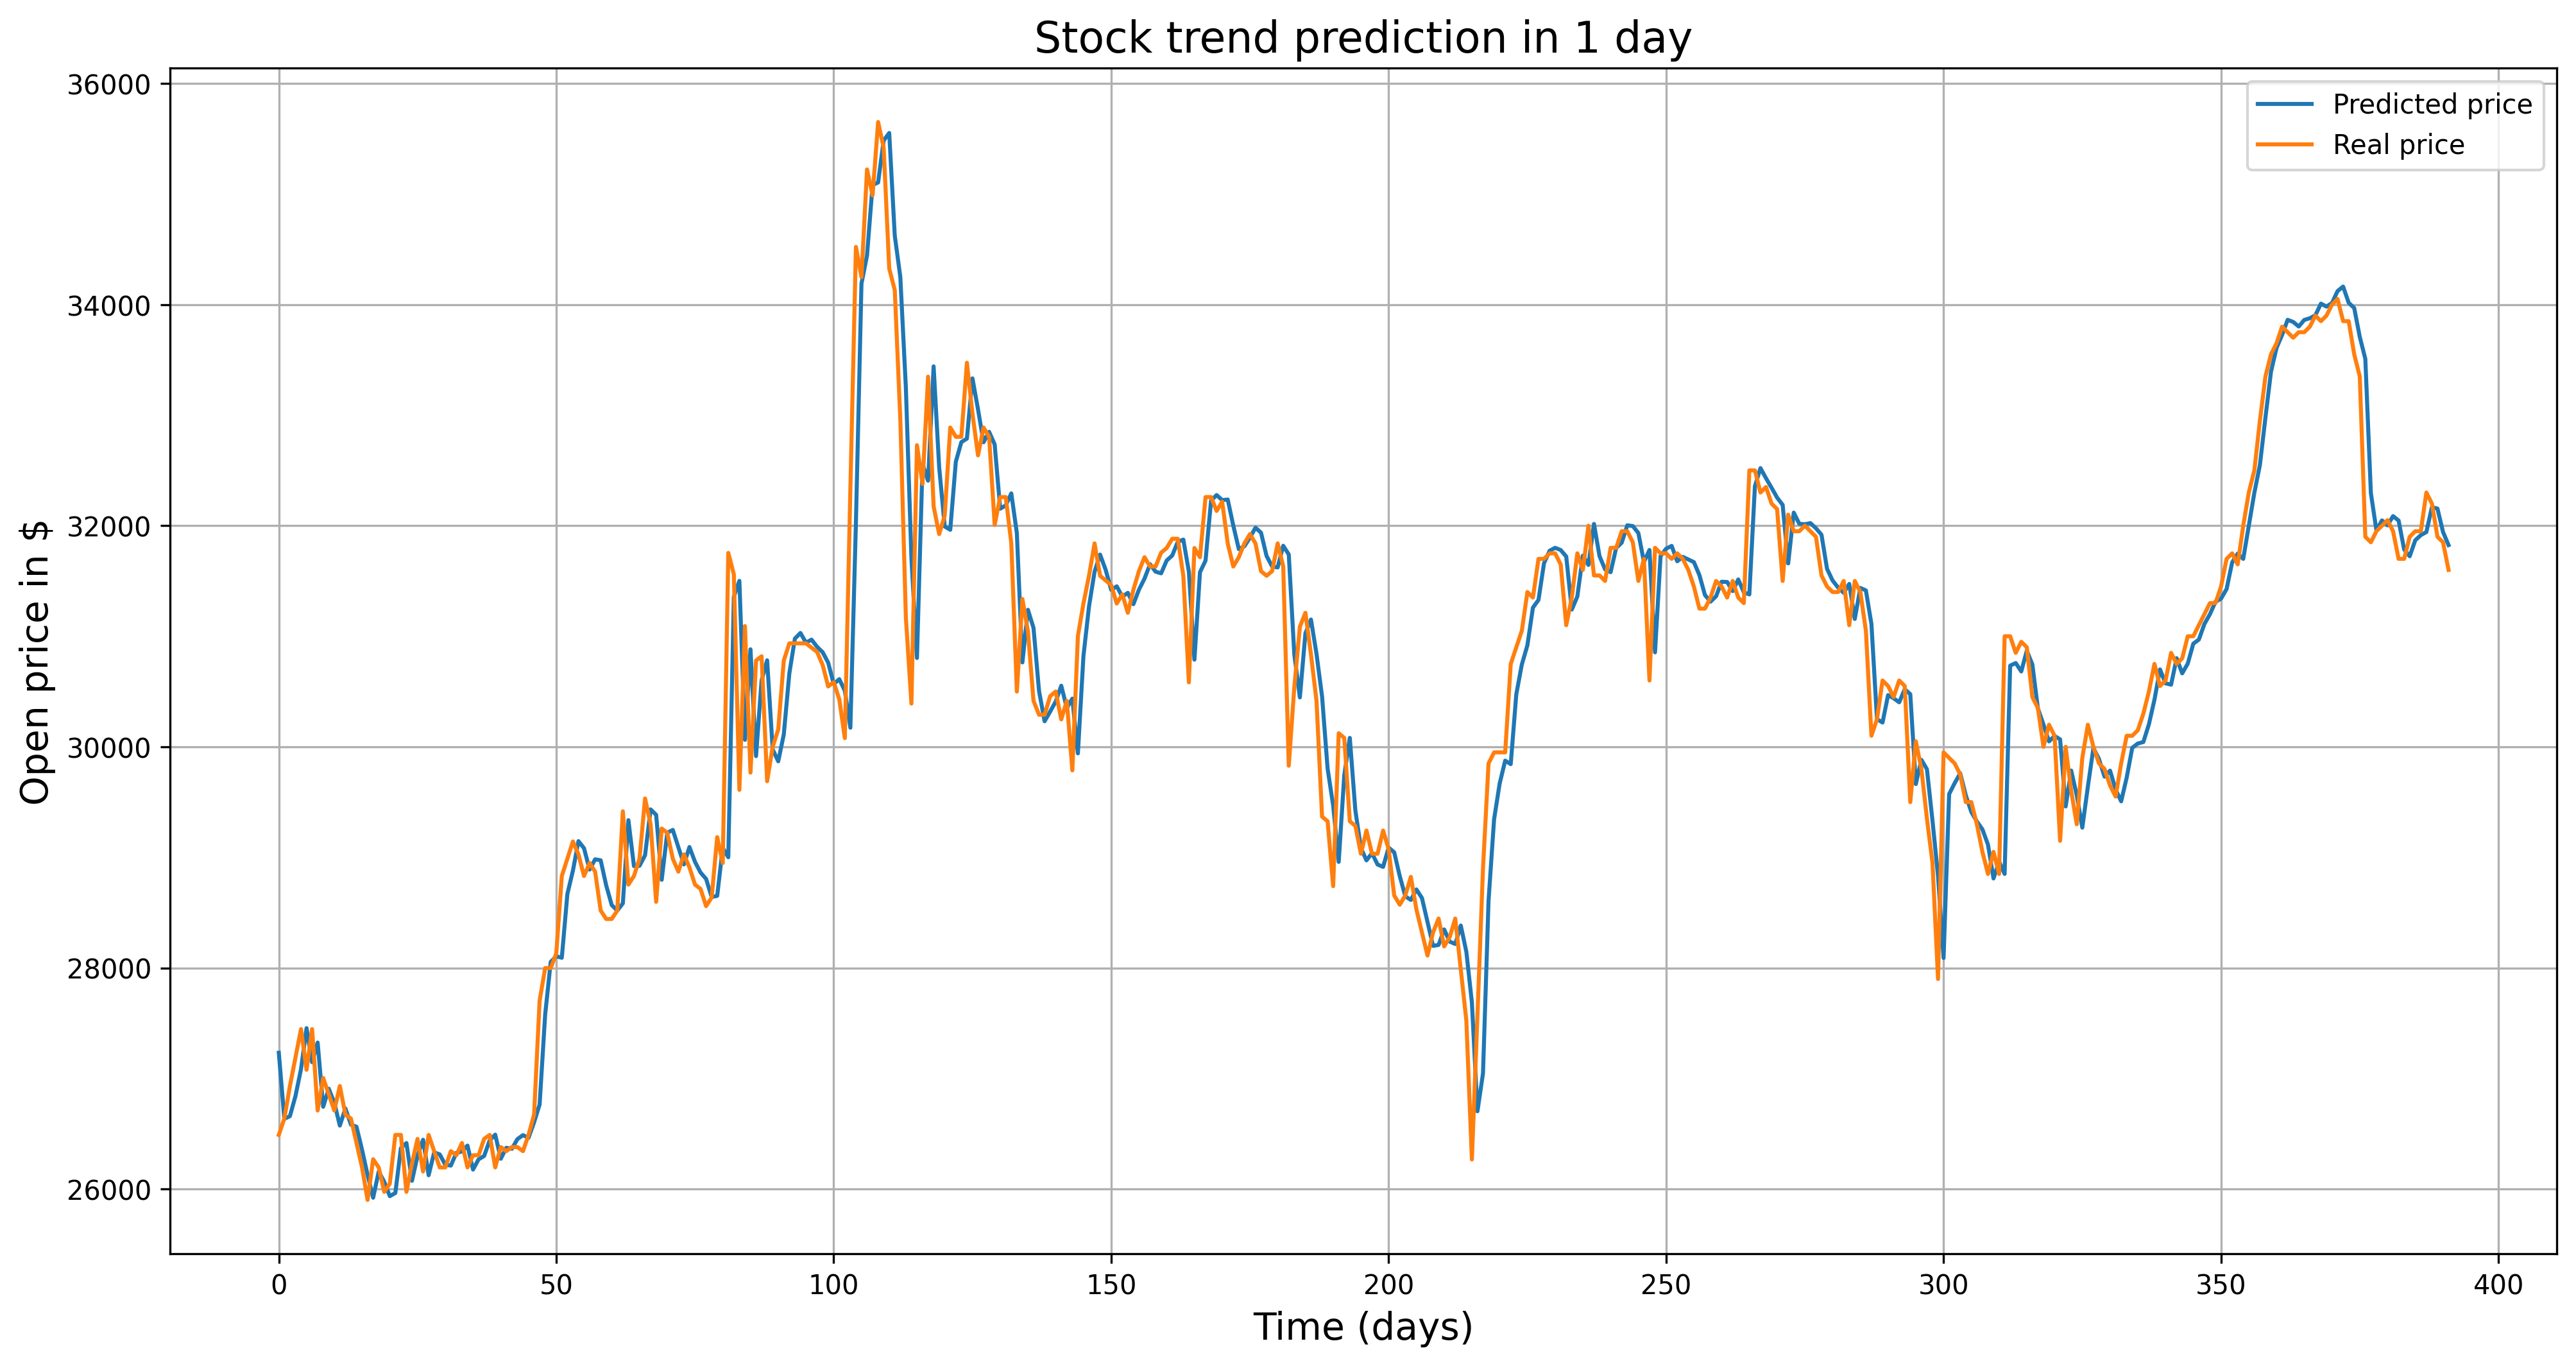

In [67]:
#conver the predicted result back to actual stock price
y_pred_same_denorm_vn = denorm(y_pred_same_vn, X_same_vn)
visualize(y_pred_same_denorm_vn, y_same_vn, 1)

### different industry

In [68]:
dif_industry_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/different industry')
X_dif_vn, y_dif_vn = prep_dataset(dif_industry_vn, window_size_1, time_1, label_range_1, 1, 5)

In [69]:
# Convert from lists to Numpy arrays for reshaping purpose
X_dif_vn = np.array(X_dif_vn)
y_dif_vn = np.array(y_dif_vn)
# Reshape the numpy array to fit the neural network input shape requirement
X_dif_vn = X_dif_vn.reshape(X_dif_vn.shape[0], 2, window_size_1, 1)

In [70]:
# MinMax normalize data: x=(x-min(x)/(max(x)-min(x))
X_dif_norm_vn, y_dif_norm_vn = normalize(X_dif_vn, y_dif_vn)

In [71]:
# Get prediction on the test data
y_pred_dif_vn = vn_model.predict(X_dif_norm_vn)
print("MSE on the test set: ", mean_squared_error(y_pred_dif_vn, y_dif_norm_vn))

21/21 [==============================] - 0s 7ms/step
MSE on the test set:  0.0076919503675742665


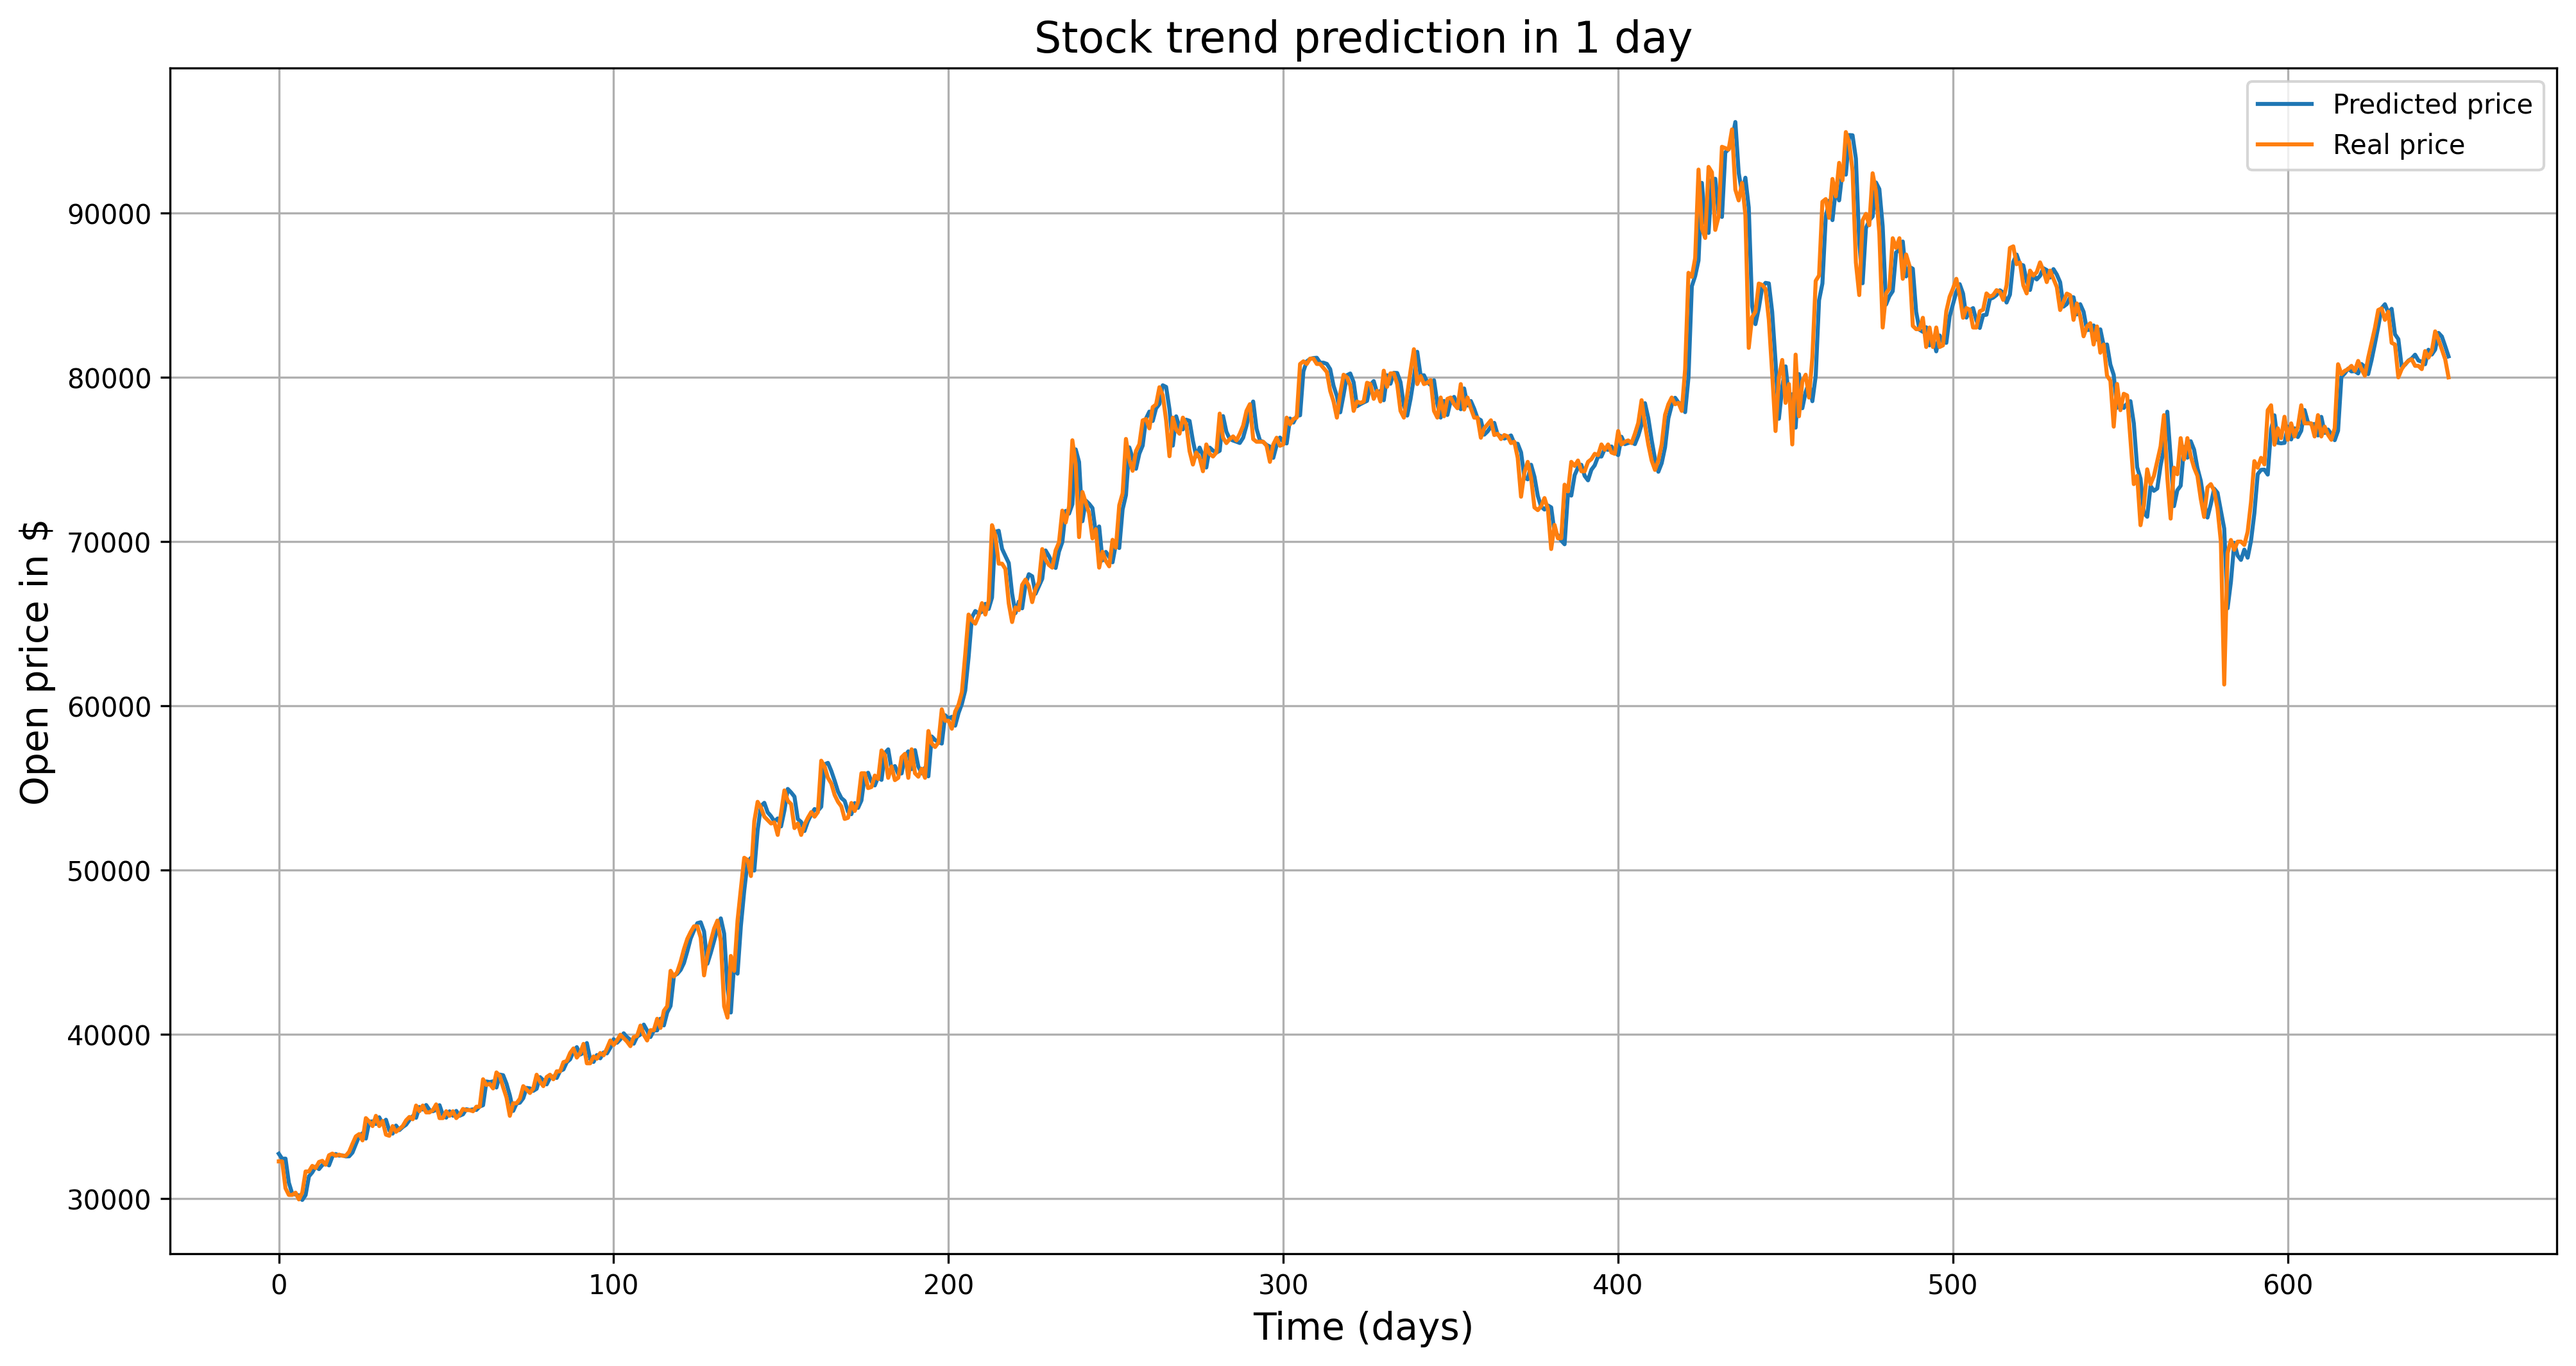

In [72]:
#conver the predicted result back to actual stock price
y_pred_dif_denorm_vn = denorm(y_pred_dif_vn, X_dif_vn)
visualize(y_pred_dif_denorm_vn, y_dif_vn, 1)

# Task 3

## Prepare training and testing data for models

In [73]:
window_size_2 = 90
time_2 = 1 #the label starts from 1 day after
label_range_2 = 7 #predict the price for the next 7 days

label_range_3 = 30 #predict the price for the next 30 days
ma5_index = 8
ma22_index = 9
open_index_vn = 2
volume_index_vn = 6

#split features and labels for training set
train_path_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/train data')
X_train_tp7, y_train_tp7 = prep_dataset(train_path_vn, window_size_2, time_2, label_range_2, open_index_vn, volume_index_vn)
X_train_tp30, y_train_tp30 = prep_dataset(train_path_vn, window_size_2, time_2, label_range_3, open_index_vn, volume_index_vn)

In [74]:
#Create 2 new Moving Average columns in training data and store each dataframe in a dictionary
ma_dict_train = {}
for filename in os.listdir(train_path_vn):
  data = pd.read_csv(filename)
  data['Date']= pd.to_datetime(data['Date'], format= '%Y-%m-%d') #change the date column to datetime format
  data = data.reset_index(drop=True)
  # Calculate the 5-day and 22-day moving averages
  data['MA 5 days'] = data['Open'].rolling(window=5).mean()
  data['MA 22 days'] = data['Open'].rolling(window=22).mean()
  data.fillna(method='bfill', inplace=True)  # Fill NaN values with the next row's value
  ma_dict_train[filename[:3]] = data  # Read the CSV file and store it in the dictionary 


X_train_ma5 = []
y_train_ma5 = []
X_train_ma22 = []
y_train_ma22 = []
for df in ma_dict_train.values():
  feature_label_split(df, X_train_ma5, y_train_ma5, window_size_2, time_2, label_range_3, ma5_index, volume_index_vn)
  feature_label_split(df, X_train_ma22, y_train_ma22, window_size_2, time_2, label_range_3, ma22_index, volume_index_vn)

In [75]:
X_train_ma5[0]

[array([[ 5862.4],
        [ 5862.4],
        [ 5862.4],
        [ 5862.4],
        [ 5862.4],
        [ 6115. ],
        [ 6093. ],
        [ 5983.2],
        [ 5917.4],
        [ 5785.6],
        [ 5588. ],
        [ 5412.4],
        [ 5357.6],
        [ 5456.4],
        [ 5643. ],
        [ 5884.4],
        [ 6060. ],
        [ 6191.6],
        [ 6169.6],
        [ 6092.8],
        [ 6005. ],
        [ 6038. ],
        [ 6071. ],
        [ 6060. ],
        [ 6005.2],
        [ 5972.2],
        [ 5972.2],
        [ 5994.2],
        [ 6104. ],
        [ 6202.8],
        [ 6279.8],
        [ 6356.6],
        [ 6433.4],
        [ 6466.4],
        [ 6532.2],
        [ 6599.8],
        [ 6656.6],
        [ 6735.2],
        [ 6759. ],
        [ 6804.6],
        [ 6881.4],
        [ 6925.2],
        [ 6980.2],
        [ 7134. ],
        [ 7409. ],
        [ 7640. ],
        [ 8002.8],
        [ 8178.8],
        [ 8255.8],
        [ 8266.8],
        [ 8321.6],
        [ 8266.6],
        [ 84

In [76]:
#split features and labels for testing set
test_path_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/test data')
X_test_tp7, y_test_tp7 = prep_dataset(test_path_vn, window_size_2, time_2, label_range_2, open_index_vn, volume_index_vn)
X_test_tp30, y_test_tp30 = prep_dataset(test_path_vn, window_size_2, time_2, label_range_3, open_index_vn, volume_index_vn)

In [77]:
#Create 2 new Moving Average columns in testing data and store each dataframe in a dictionary
ma_dict_test = {}
for filename in os.listdir(test_path_vn):
  data = pd.read_csv(filename)
  data['Date']= pd.to_datetime(data['Date'], format= '%Y-%m-%d') #change the date column to datetime format
  data = data.reset_index(drop=True)
  data['MA 5 days'] = data['Open'].rolling(window=5).mean()
  data['MA 22 days'] = data['Open'].rolling(window=22).mean()
  data.fillna(method='bfill', inplace=True)  # Fill NaN values with the next row's value
  ma_dict_test[filename[:3]] = data  # Read the CSV file and store it in the dictionary 


X_test_ma5 = []
y_test_ma5 = []
X_test_ma22 = []
y_test_ma22 = []
for df in ma_dict_test.values():
  feature_label_split(df, X_test_ma5, y_test_ma5, window_size_2, time_2, label_range_3, ma5_index, volume_index_vn)
  feature_label_split(df, X_test_ma22, y_test_ma22, window_size_2, time_2, label_range_3, ma22_index, volume_index_vn)

In [78]:
print(np.array(y_test_ma22).shape)

(6656, 30)


In [79]:
#split train and validation set
X_train_tp7, X_val_tp7, y_train_tp7, y_val_tp7 = train_test_split(X_train_tp7, y_train_tp7, test_size=0.2, shuffle=False)
X_train_tp30, X_val_tp30, y_train_tp30, y_val_tp30 = train_test_split(X_train_tp30, y_train_tp30, test_size=0.2, shuffle=False)
X_train_ma5, X_val_ma5, y_train_ma5, y_val_ma5 = train_test_split(X_train_ma5, y_train_ma5, test_size=0.2, shuffle=False)
X_train_ma22, X_val_ma22, y_train_ma22, y_val_ma22 = train_test_split(X_train_ma22, y_train_ma22, test_size=0.2, shuffle=False)

In [80]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
X_train_norm_tp7, y_train_norm_tp7 = normalize(X_train_tp7, y_train_tp7)
X_val_norm_tp7, y_val_norm_tp7 = normalize(X_val_tp7, y_val_tp7)
X_test_norm_tp7, y_test_norm_tp7 = normalize(X_test_tp7, y_test_tp7)

X_train_norm_tp30, y_train_norm_tp30 = normalize(X_train_tp30, y_train_tp30)
X_val_norm_tp30, y_val_norm_tp30 = normalize(X_val_tp30, y_val_tp30)
X_test_norm_tp30, y_test_norm_tp30 = normalize(X_test_tp30, y_test_tp30)

X_train_norm_ma5, y_train_norm_ma5 = normalize(X_train_ma5, y_train_ma5)
X_val_norm_ma5, y_val_norm_ma5 = normalize(X_val_ma5, y_val_ma5)
X_test_norm_ma5, y_test_norm_ma5 = normalize(X_test_ma5, y_test_ma5)

X_train_norm_ma22, y_train_norm_ma22 = normalize(X_train_ma22, y_train_ma22)
X_val_norm_ma22, y_val_norm_ma22 = normalize(X_val_ma22, y_val_ma22)
X_test_norm_ma22, y_test_norm_ma22 = normalize(X_test_ma22, y_test_ma22)

In [81]:
#reshape to fit the neural network input shape requirement
X_train_norm_tp7, y_train_norm_tp7, X_test_norm_tp7, y_test_norm_tp7, X_val_norm_tp7, y_val_norm_tp7 = reshape_1d(X_train_norm_tp7, y_train_norm_tp7, X_test_norm_tp7, y_test_norm_tp7, X_val_norm_tp7, y_val_norm_tp7, window_size_2)
X_train_norm_tp30, y_train_norm_tp30, X_test_norm_tp30, y_test_norm_tp30, X_val_norm_tp30, y_val_norm_tp30 = reshape_1d(X_train_norm_tp30, y_train_norm_tp30, X_test_norm_tp30, y_test_norm_tp30, X_val_norm_tp30, y_val_norm_tp30, window_size_2)
X_train_norm_ma5, y_train_norm_ma5, X_test_norm_ma5, y_test_norm_ma5, X_val_norm_ma5, y_val_norm_ma5 = reshape_1d(X_train_norm_ma5, y_train_norm_ma5, X_test_norm_ma5, y_test_norm_ma5, X_val_norm_ma5, y_val_norm_ma5, window_size_2)
X_train_norm_ma22, y_train_norm_ma22, X_test_norm_ma22, y_test_norm_ma22, X_val_norm_ma22, y_val_norm_ma22 = reshape_1d(X_train_norm_ma22, y_train_norm_ma22, X_test_norm_ma22, y_test_norm_ma22, X_val_norm_ma22, y_val_norm_ma22, window_size_2)

Shape of training set:  (13416, 2, 90, 1)
Shape of validation set:  (3355, 2, 90, 1)
Shape of test set:  (6909, 2, 90, 1)
Shape of training set:  (13232, 2, 90, 1)
Shape of validation set:  (3309, 2, 90, 1)
Shape of test set:  (6656, 2, 90, 1)
Shape of training set:  (13232, 2, 90, 1)
Shape of validation set:  (3309, 2, 90, 1)
Shape of test set:  (6656, 2, 90, 1)
Shape of training set:  (13232, 2, 90, 1)
Shape of validation set:  (3309, 2, 90, 1)
Shape of test set:  (6656, 2, 90, 1)


In [82]:
print(y_train_norm_ma5[0])

[0.78891828 0.76548056 0.75140086 0.77486703 0.8061268  0.83582217
 0.85925989 0.87800438 0.86548909 0.84048696 0.82330688 0.79830475
 0.82834144 0.87368092 0.91276275 0.95357966 0.99408368 0.98594874
 0.98190972 0.97989021 0.96970731 0.96359189 0.95750491 0.9656114
 0.97374634 0.96563984 0.96160082 0.96566829 0.95958131 0.95144637]


## Model architecture

In [83]:
# Build the model architecture
tp7_model = tf.keras.Sequential()
tp7_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(2, window_size_2, 1), padding='same'))
tp7_model.add(MaxPooling2D(pool_size=(1,2)))
tp7_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
tp7_model.add(MaxPooling2D(1, 2))
tp7_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
tp7_model.add(MaxPooling2D(1, 2))
tp7_model.add(Flatten())
tp7_model.add(Dense(100, activation='relu'))
tp7_model.add(Dense(7)) # By default: activation='linear', i.e., passing through f(x) = x

In [84]:
# Build the model architecture
tp30_model = tf.keras.Sequential()
tp30_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(2, window_size_2, 1), padding='same'))
tp30_model.add(MaxPooling2D(pool_size=(1,2)))
tp30_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
tp30_model.add(MaxPooling2D(1, 2))
tp30_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
tp30_model.add(MaxPooling2D(1, 2))
tp30_model.add(Flatten())
tp30_model.add(Dense(100, activation='relu'))
tp30_model.add(Dense(30)) # By default: activation='linear', i.e., passing through f(x) = x

In [85]:
# Build the model architecture
ma5_model = tf.keras.Sequential()
ma5_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(2, window_size_2, 1), padding='same'))
ma5_model.add(MaxPooling2D(pool_size=(1,2)))
ma5_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
ma5_model.add(MaxPooling2D(1, 2))
ma5_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
ma5_model.add(MaxPooling2D(1, 2))
ma5_model.add(Flatten())
ma5_model.add(Dense(100, activation='relu'))
ma5_model.add(Dense(30)) # By default: activation='linear', i.e., passing through f(x) = x

In [86]:
# Build the model architecture
ma22_model = tf.keras.Sequential()
ma22_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(2, window_size_2, 1), padding='same'))
ma22_model.add(MaxPooling2D(pool_size=(1,2)))
ma22_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
ma22_model.add(MaxPooling2D(1, 2))
ma22_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
ma22_model.add(MaxPooling2D(1, 2))
ma22_model.add(Flatten())
ma22_model.add(Dense(100, activation='relu'))
ma22_model.add(Dense(30)) # By default: activation='linear', i.e., passing through f(x) = x

## Train models

In [87]:
#compile the model
tp7_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
tp30_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
ma5_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
ma22_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [88]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mse', patience=3, restore_best_weights=True)

In [89]:
np.array(X_train_norm_tp7).shape

(13416, 2, 90, 1)

In [90]:
history_tp7 = tp7_model.fit(X_train_norm_tp7, y_train_norm_tp7, validation_data=(X_val_norm_tp7,y_val_norm_tp7), epochs=20, batch_size=512, callbacks=[early_stopping])

Epoch 1/20
27/27 [==============================] - 11s 338ms/step - loss: 0.1643 - mse: 0.1643 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 2/20
27/27 [==============================] - 11s 401ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/20
27/27 [==============================] - 10s 387ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 4/20
27/27 [==============================] - 8s 309ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 5/20
27/27 [==============================] - 10s 392ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 6/20
27/27 [==============================] - 10s 377ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 7/20
27/27 [==============================] - 9s 309ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 8/20
27/27 [==============================] - 10s 384ms/step - lo

In [91]:
history_tp30 = tp30_model.fit(X_train_norm_tp30, y_train_norm_tp30, validation_data=(X_val_norm_tp30,y_val_norm_tp30), epochs=20, batch_size=512, callbacks=[early_stopping])

Epoch 1/20
26/26 [==============================] - 12s 420ms/step - loss: 0.4704 - mse: 0.4704 - val_loss: 0.1828 - val_mse: 0.1828
Epoch 2/20
26/26 [==============================] - 10s 406ms/step - loss: 0.1832 - mse: 0.1832 - val_loss: 0.1202 - val_mse: 0.1202
Epoch 3/20
26/26 [==============================] - 9s 329ms/step - loss: 0.1493 - mse: 0.1493 - val_loss: 0.1025 - val_mse: 0.1025
Epoch 4/20
26/26 [==============================] - 11s 409ms/step - loss: 0.1417 - mse: 0.1417 - val_loss: 0.0999 - val_mse: 0.0999
Epoch 5/20
26/26 [==============================] - 10s 403ms/step - loss: 0.1396 - mse: 0.1396 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 6/20
26/26 [==============================] - 8s 316ms/step - loss: 0.1404 - mse: 0.1404 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 7/20
26/26 [==============================] - 10s 401ms/step - loss: 0.1406 - mse: 0.1406 - val_loss: 0.1020 - val_mse: 0.1020
Epoch 8/20
26/26 [==============================] - 10s 406ms/step - lo

In [92]:
history_ma5 = ma5_model.fit(X_train_norm_ma5, y_train_norm_ma5, validation_data=(X_val_norm_ma5,y_val_norm_ma5), epochs=20, batch_size=512, callbacks=[early_stopping])

Epoch 1/20
26/26 [==============================] - 12s 430ms/step - loss: 0.3227 - mse: 0.3227 - val_loss: 0.1270 - val_mse: 0.1270
Epoch 2/20
26/26 [==============================] - 11s 417ms/step - loss: 0.2279 - mse: 0.2279 - val_loss: 0.1233 - val_mse: 0.1233
Epoch 3/20
26/26 [==============================] - 9s 330ms/step - loss: 0.2227 - mse: 0.2227 - val_loss: 0.1160 - val_mse: 0.1160
Epoch 4/20
26/26 [==============================] - 11s 422ms/step - loss: 0.2176 - mse: 0.2176 - val_loss: 0.1191 - val_mse: 0.1191
Epoch 5/20
26/26 [==============================] - 11s 418ms/step - loss: 0.2132 - mse: 0.2132 - val_loss: 0.1150 - val_mse: 0.1150
Epoch 6/20
26/26 [==============================] - 9s 355ms/step - loss: 0.2119 - mse: 0.2119 - val_loss: 0.1136 - val_mse: 0.1136
Epoch 7/20
26/26 [==============================] - 10s 384ms/step - loss: 0.2099 - mse: 0.2099 - val_loss: 0.1132 - val_mse: 0.1132
Epoch 8/20
26/26 [==============================] - 11s 418ms/step - lo

In [93]:
history_ma22 = ma22_model.fit(X_train_norm_ma22, y_train_norm_ma22, validation_data=(X_val_norm_ma22,y_val_norm_ma22), epochs=20, batch_size=512, callbacks=[early_stopping])

Epoch 1/20
26/26 [==============================] - 12s 423ms/step - loss: 0.5234 - mse: 0.5234 - val_loss: 0.1646 - val_mse: 0.1646
Epoch 2/20
26/26 [==============================] - 11s 438ms/step - loss: 0.2839 - mse: 0.2839 - val_loss: 0.1152 - val_mse: 0.1152
Epoch 3/20
26/26 [==============================] - 8s 324ms/step - loss: 0.2497 - mse: 0.2497 - val_loss: 0.1056 - val_mse: 0.1056
Epoch 4/20
26/26 [==============================] - 11s 416ms/step - loss: 0.2414 - mse: 0.2414 - val_loss: 0.1165 - val_mse: 0.1165
Epoch 5/20
26/26 [==============================] - 11s 413ms/step - loss: 0.2400 - mse: 0.2400 - val_loss: 0.0977 - val_mse: 0.0977
Epoch 6/20
26/26 [==============================] - 9s 329ms/step - loss: 0.2317 - mse: 0.2317 - val_loss: 0.1051 - val_mse: 0.1051
Epoch 7/20
26/26 [==============================] - 11s 415ms/step - loss: 0.2255 - mse: 0.2255 - val_loss: 0.1105 - val_mse: 0.1105
Epoch 8/20
26/26 [==============================] - 11s 418ms/step - lo

## Test models

In [94]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
# Get prediction on the test data
y_pred_norm_tp7 = tp7_model.predict(X_test_norm_tp7)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_tp7, y_test_norm_tp7))
#conver the predicted result back to actual stock price
y_pred_denorm_tp7 = denorm(y_pred_norm_tp7, X_test_tp7)

216/216 [==============================] - 2s 8ms/step
MSE on the test set:  0.03164945777051674


In [95]:
y_pred_denorm_tp7[100]

array([17713.6  , 17822.121, 17891.727, 17801.584, 17850.271, 17890.691,
       17928.96 ], dtype=float32)

In [96]:
# Get prediction on the test data
y_pred_norm_tp30 = tp30_model.predict(X_test_norm_tp30)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_tp30, y_test_norm_tp30))
#conver the predicted result back to actual stock price
y_pred_denorm_tp30 = denorm(y_pred_norm_tp30, X_test_tp30)

208/208 [==============================] - 2s 10ms/step
MSE on the test set:  0.12519511581625592


In [97]:
# Get prediction on the test data
y_pred_norm_ma5 = ma5_model.predict(X_test_norm_ma5)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_ma5, y_test_norm_ma5))
#conver the predicted result back to actual stock price
y_pred_denorm_ma5 = denorm(y_pred_norm_ma5, X_test_ma5)

208/208 [==============================] - 3s 12ms/step
MSE on the test set:  0.16722129971357788


In [98]:
# Get prediction on the test data
y_pred_norm_ma22 = ma22_model.predict(X_test_norm_ma22)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_ma22, y_test_norm_ma22))
#conver the predicted result back to actual stock price
y_pred_denorm_ma22 = denorm(y_pred_norm_ma22, X_test_ma22)

208/208 [==============================] - 2s 7ms/step
MSE on the test set:  0.14520146134616013


## Suggestion for trading point

### 7 days trading suggestion

In [99]:
#set the desire day to predict on the testing set
#let's say we are at day t and want to make suggestion for day t+1 to day t+7
# t=100
day = 100 

In [100]:
X_test_tp7[day]

[array([[11864.],
        [11766.],
        [11667.],
        [11815.],
        [12701.],
        [12504.],
        [12553.],
        [12455.],
        [12799.],
        [12652.],
        [13184.],
        [13312.],
        [13568.],
        [13440.],
        [13504.],
        [13568.],
        [13824.],
        [13696.],
        [13568.],
        [13504.],
        [13440.],
        [13504.],
        [13312.],
        [13184.],
        [13376.],
        [13376.],
        [13312.],
        [13568.],
        [13568.],
        [13632.],
        [13760.],
        [13952.],
        [14080.],
        [14272.],
        [14336.],
        [14208.],
        [14208.],
        [14528.],
        [14336.],
        [14272.],
        [14336.],
        [14720.],
        [15104.],
        [15360.],
        [14848.],
        [14848.],
        [15168.],
        [14976.],
        [15040.],
        [15360.],
        [15680.],
        [16000.],
        [16256.],
        [16256.],
        [16192.],
        [1

In [101]:
X_test_tp7[day][0][window_size_2 - 1][0]

17984.0

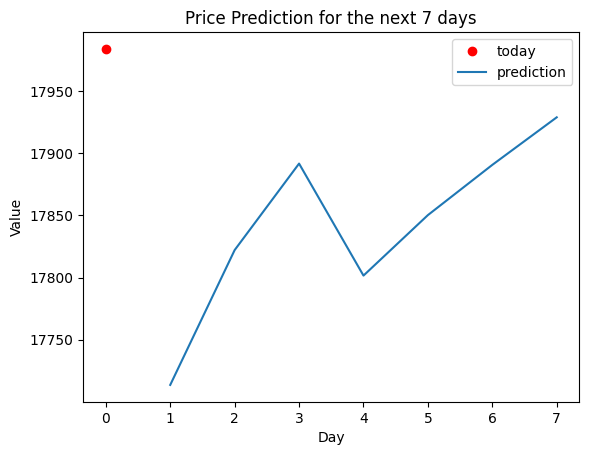

In [102]:
#Plot the price for day t and the prediction
plt.plot([0], [X_test_tp7[day][0][window_size_2 - 1]], 'ro', label='today')
plt.plot(range(1, len(y_pred_denorm_tp7[day]) + 1), y_pred_denorm_tp7[day], label='prediction')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Price Prediction for the next 7 days')
plt.legend()
plt.show()

In [103]:
#determine the buying point base on return on investment
t_price = X_test_tp7[day][0][window_size_2 - 1][0] #today's price is the last day in the sample, index = window_size - 1
highest_price = y_pred_denorm_tp7[day].max() #the highest price in the next 7 days
highest_day = np.argmax(y_pred_denorm_tp7[day])
roi = (highest_price - t_price)/t_price
if roi >= 0:
  print(f'If we buy the stock today at {t_price}, there is a chance that the price can increase to {highest_price} which give us a {round(roi*100, 2)}% return on investment after {highest_day + 1} days.')
else:
  print(f'It might not be best to buy the stock today at {t_price} because the price will decrease over the next {label_range_2} days.')

It might not be best to buy the stock today at 17984.0 because the price will decrease over the next 7 days.


In [104]:
# validate the prediction and the actual price
highest_price_true = y_test_tp7[day].max()
highest_day_true = np.argmax(y_pred_denorm_tp7[day])
print(f'The actual highest price is {highest_price_true} and the predicted price is {highest_price}')
print(f'The actual highest day is {highest_day_true + 1} and the predicted day is {highest_day + 1}')

The actual highest price is 18528.0 and the predicted price is 17928.9609375
The actual highest day is 7 and the predicted day is 7


In [105]:
#determine the selling point
if highest_price > t_price:
  print(f'After {highest_day + 1} days, there is a chance that the price will increase by {round(roi*100, 2)}% and will be highest at {highest_price}')
else:
  print(f'We can consider selling the stock today at {t_price} because the price will decrease over the next {label_range_2} days')

We can consider selling the stock today at 17984.0 because the price will decrease over the next 7 days


### 1 month Moving Average Trading Signal

In [106]:
#get the predictions from the tp30, ma5, ma22 model
tp30_pre = y_pred_denorm_tp30[day]
ma5_pre = y_pred_denorm_ma5[day]
ma22_pre = y_pred_denorm_ma22[day]

In [107]:
y_pred_denorm_tp30[0]

array([11866.486, 11983.962, 12002.619, 11898.593, 11792.328, 11874.666,
       12185.021, 12331.859, 12118.697, 12105.479, 12079.18 , 12183.569,
       12433.812, 12203.828, 12284.061, 12224.199, 12153.295, 12302.61 ,
       12209.826, 12225.564, 12286.057, 12412.571, 12567.516, 12359.596,
       12275.789, 12565.479, 12424.959, 12404.723, 12333.381, 12394.848],
      dtype=float32)

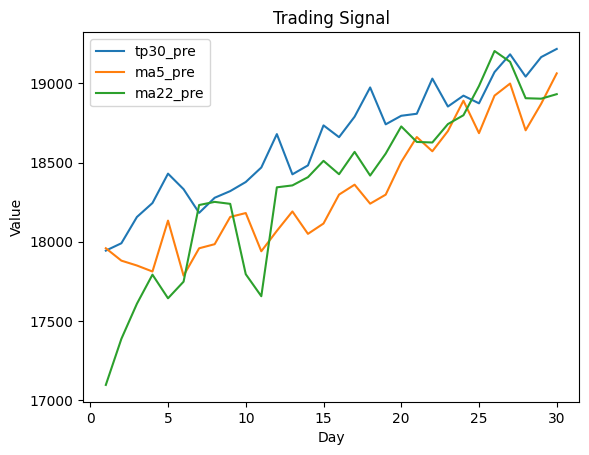

In [108]:
#Plot the trend lines for the next 30 days
days = range(1, len(tp30_pre) + 1)

plt.plot(days, tp30_pre, label='tp30_pre')
plt.plot(days, ma5_pre, label='ma5_pre')
plt.plot(days, ma22_pre, label='ma22_pre')

plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Trading Signal')
plt.legend()

plt.show()

# Task 4

## Expected return and risk

In [109]:
#store the dataframes in dictionary
data_dict = {}
test_path_vn = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/test data')
for filename in os.listdir(test_path_vn):
  data = pd.read_csv(filename)
  data = data.reset_index(drop=True)
  data_dict[filename[:3]] = data  # Read the CSV file and store it in the dictionary

In [110]:
#compute the daily return for each company
for company in data_dict:
  data_dict[company]['Daily Return'] = data_dict[company]['Open'].pct_change()

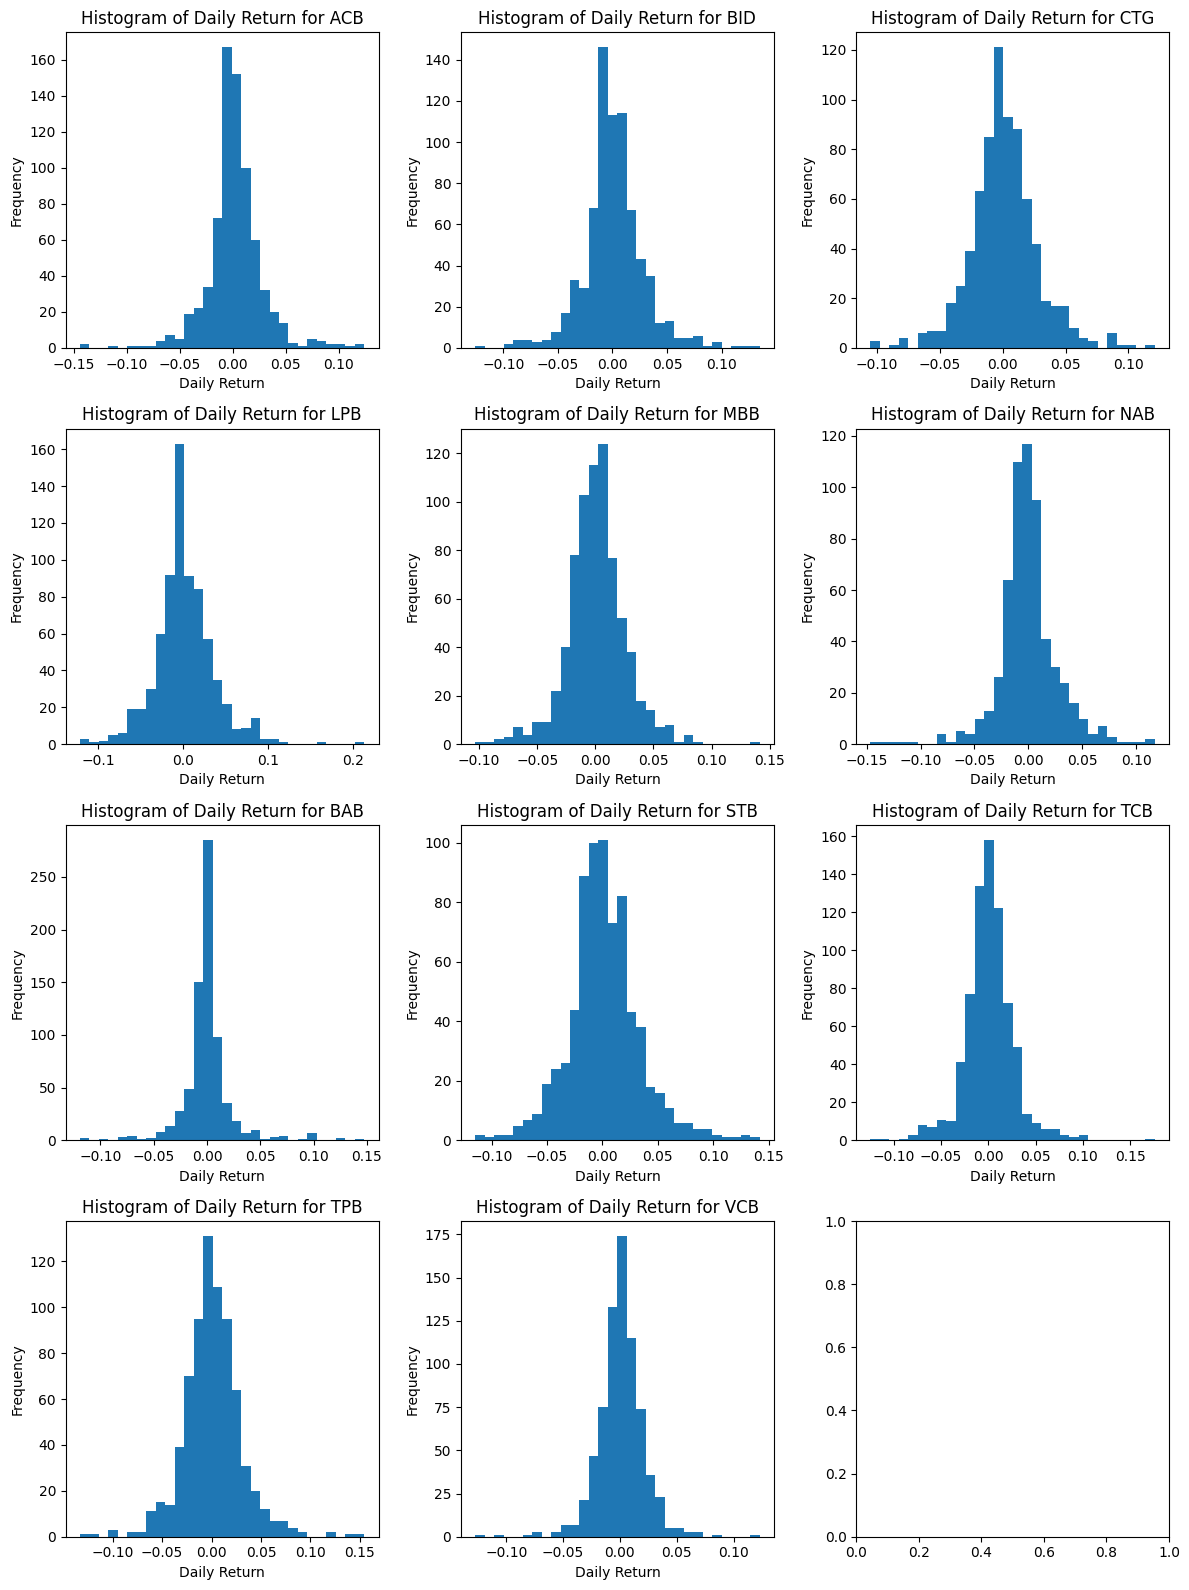

In [111]:
#Plot the histograms of daily return for each company
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

companies = list(data_dict.keys())
for i, company in enumerate(companies):
  row = i // num_cols
  col = i % num_cols

  data_frame = data_dict[company]
  daily_returns = data_frame['Daily Return']

  axes[row, col].hist(daily_returns, bins=30)
  axes[row, col].set_title(f'Histogram of Daily Return for {company}')
  axes[row, col].set_xlabel('Daily Return')
  axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [112]:
#compute the average daily return and standard deviation of daily return for each company and store in dictionary
average_daily_returns_exp = {}
sd_daily_returns_exp = {}

for company, data_frame in data_dict.items():
    daily_returns = data_frame['Daily Return']
    average_return = daily_returns.mean()
    sd_deviation = daily_returns.std()
    average_daily_returns_exp[company] = average_return
    sd_daily_returns_exp[company] = sd_deviation

print('Average Daily Return:')
for company, average_return in average_daily_returns_exp.items():
    sd_deviation = sd_daily_returns_exp[company]
    print(f"{company}: Average Daily Return = {average_return:.6f}%, Standard Deviation = {sd_deviation:.6f}")

Average Daily Return:
ACB: Average Daily Return = 0.001461%, Standard Deviation = 0.026388
BID: Average Daily Return = 0.001041%, Standard Deviation = 0.027794
CTG: Average Daily Return = 0.001080%, Standard Deviation = 0.026982
LPB: Average Daily Return = 0.002103%, Standard Deviation = 0.034502
MBB: Average Daily Return = 0.001178%, Standard Deviation = 0.025312
NAB: Average Daily Return = -0.000116%, Standard Deviation = 0.028143
BAB: Average Daily Return = 0.000249%, Standard Deviation = 0.022735
STB: Average Daily Return = 0.001661%, Standard Deviation = 0.032732
TCB: Average Daily Return = 0.000879%, Standard Deviation = 0.026483
TPB: Average Daily Return = 0.001343%, Standard Deviation = 0.029386
VCB: Average Daily Return = 0.000938%, Standard Deviation = 0.020642


In [113]:
#compute the average monthly return and standard deviation of monthly return for each company and store in dictionary
average_monthly_returns_exp = {}
sd_monthly_returns_exp = {}
for company, data_frame in data_dict.items():
    data_frame['Date'] = pd.to_datetime(data_frame['Date'])
    data_frame.set_index('Date', inplace=True)
    daily_returns = data_frame['Daily Return']
    monthly_returns = daily_returns.resample('M').sum()
    sd_deviation = monthly_returns.std()
    average_monthly_return = monthly_returns.mean()
    average_monthly_returns_exp[company] = average_monthly_return
    sd_monthly_returns_exp[company] = sd_deviation

print("Average Monthly Returns:")
for company, average_monthly_return in average_monthly_returns_exp.items():
  sd_deviation = sd_monthly_returns_exp[company]
  print(f"{company}: Average Daily Return = {average_monthly_return:.6f}%, Standard Deviation = {sd_deviation:.6f}")

Average Monthly Returns:
ACB: Average Daily Return = 0.029785%, Standard Deviation = 0.093299
BID: Average Daily Return = 0.021380%, Standard Deviation = 0.113702
CTG: Average Daily Return = 0.022168%, Standard Deviation = 0.117790
LPB: Average Daily Return = 0.042581%, Standard Deviation = 0.135168
MBB: Average Daily Return = 0.024173%, Standard Deviation = 0.108262
NAB: Average Daily Return = -0.002378%, Standard Deviation = 0.134189
BAB: Average Daily Return = 0.005077%, Standard Deviation = 0.084601
STB: Average Daily Return = 0.034089%, Standard Deviation = 0.134802
TCB: Average Daily Return = 0.018039%, Standard Deviation = 0.120859
TPB: Average Daily Return = 0.027578%, Standard Deviation = 0.114323
VCB: Average Daily Return = 0.019252%, Standard Deviation = 0.089071


## Predicted Return

### Prepare data feature

In [114]:
open_index_vn = 2
volume_index_vn = 6
window_size_2 = 90
time_2 = 1
label_range_2 = 7

In [115]:
#prepare the data feature to match the tp7 model input shape
feature7 = {}
for company, data_frame in data_dict.items():
  X = []
  for i in range(0, len(data_frame) - window_size_2 - time_2 - label_range_2 + 1):
    data_feature = [[], []]
    # Get a window_size time frame for data feature
    for j in range(window_size_2):
        data_feature[0].append(data_frame.iloc[i + j, open_index_vn])  # Append Open price to first list
        data_feature[1].append(data_frame.iloc[i + j, volume_index_vn])  # Append Volume to second list
    # Append new data sample (feature and label) to X_data and y_data
    X.append([np.array(data_feature[0]).reshape(window_size_2, 1),
              np.array(data_feature[1]).reshape(window_size_2, 1)])
  feature7[company] = X

In [116]:
#normalize the data feature
feature7_norm = {}
for company, feature in feature7.items():
  X_norm = np.copy(feature)
  for i in range(0, len(feature)):
      #normalize feature 0
      min_feature_0 = np.min(feature[i][0])
      max_feature_0 = np.max(feature[i][0])
      X_norm[i][0] = (feature[i][0] - min_feature_0) / (max_feature_0 - min_feature_0)
      #normalize feature 1
      min_feature_1 = np.min(feature[i][1])
      max_feature_1 = np.max(feature[i][1])
      X_norm[i][1] = (feature[i][1] - min_feature_1) / (max_feature_1 - min_feature_1)
  X_norm = np.array(X_norm)
  X_norm = np.reshape(X_norm, (X_norm.shape[0], 2, window_size_2, 1))
  feature7_norm[company] = X_norm

In [117]:
#use the tp7 model to make prediction for each company and store in dictionary
prediction_7 = {}
for company, feature in feature7_norm.items():
  y_pre7 = tp7_model.predict(feature)
  prediction_7[company] = y_pre7

21/21 [==============================] - 0s 7ms/step


### Returns

In [118]:
prediction_day = 0 #set the day to make prediction

#compute the average daily return base on 7 days prediction
average_daily_returns_pre = {} 

for company, prediction in prediction_7.items():
  selected_sample = prediction[prediction_day]
  returns = []
  for i in range(1, len(selected_sample)):
    daily_return = (selected_sample[i] - selected_sample[i-1]) / selected_sample[i-1]
    returns.append(daily_return)

  average_return = np.mean(returns)
  average_daily_returns_pre[company] = average_return

In [119]:
average_daily_returns_pre

{'ACB': 0.007042568,
 'BID': 0.0029627855,
 'CTG': 0.003928767,
 'LPB': 0.005169321,
 'MBB': 0.003632229,
 'NAB': 0.00056550215,
 'BAB': 0.003395103,
 'STB': 0.004120185,
 'TCB': 0.0036709525,
 'TPB': 0.002876845,
 'VCB': 0.0038128549}

## Ranking

In [120]:
# Financial Ratio
pe = {'ACB': 6.2, 'BID': 12.7, 'CTG': 8, 'LPB': 5.5, 'MBB': 4.6, 'NAB': 4.6,
 'BAB': 15.8, 'STB': 9.5, 'TCB': 4.8,'TPB': 6.1, 'VCB': 14.7}

pb = {'ACB': 1.5, 'BID': 2.2, 'CTG': 1.3, 'LPB': 1, 'MBB': 1, 'NAB': 0.6,
 'BAB': 1.4, 'STB': 1.2, 'TCB': 0.8, 'TPB': 1.2, 'VCB': 3.2}

roe = {'ACB': 0.265, 'BID': 0.199, 'CTG': 0.169, 'LPB': 0.221, 'MBB': 0.258, 'NAB': 0.171,
 'BAB': 0.091, 'STB': 0.138, 'TCB': 0.197, 'TPB': 0.215, 'VCB': 0.24}

roa = {'ACB': 0.024, 'BID': 0.009, 'CTG': 0.01, 'LPB': 0.221, 'MBB': 0.026, 'NAB': 0.011,
 'BAB': 0.007, 'STB': 0.009, 'TCB': 0.032, 'TPB': 0.02, 'VCB': 0.019}

In [121]:
def normalize_dict_values(dictionary, min_range, max_range):
    min_value = min(dictionary.values())
    max_value = max(dictionary.values())
    
    normalized_dict = {}
    for key, value in dictionary.items():
        normalized_value = ((value - min_value) / (max_value - min_value)) * (max_range - min_range) + min_range
        normalized_dict[key] = normalized_value
    
    return normalized_dict

In [122]:
norm_pe = normalize_dict_values(pe, 1, 2)
norm_pb = normalize_dict_values(pb, 1, 2)
norm_roa = normalize_dict_values(roa, 1, 2)
norm_roe = normalize_dict_values(roe, 1, 2)

norm_average_daily_returns_pre = normalize_dict_values(average_daily_returns_pre, 1, 2)
norm_average_monthly_returns_exp = normalize_dict_values(average_monthly_returns_exp, 1, 2)
norm_sd_daily_returns_exp = normalize_dict_values(sd_daily_returns_exp, 1,2)
norm_sd_monthly_returns_exp = normalize_dict_values(sd_monthly_returns_exp, 1,2)
norm_average_daily_returns_exp = normalize_dict_values(average_daily_returns_exp, 1, 2)

In [123]:
metric_scores = {}

for company, avg_return_pre in norm_average_daily_returns_pre.items():
    monthly_return = norm_average_monthly_returns_exp[company]
    std_daily_exp = norm_sd_daily_returns_exp[company]
    std_monthly_exp = norm_sd_monthly_returns_exp[company]
    avg_daily_returns_exp = norm_average_daily_returns_exp[company]
    pb_ = norm_pb[company]
    pe_ = norm_pb[company]
    roe_ = norm_roe[company]
    roa_ = norm_roa[company]
    # Calculate the metric score
    metric_score = ((0.5*avg_return_pre) + (0.15*(1/std_daily_exp)) + (0.05*(1/std_monthly_exp))
                    + (0.15*avg_daily_returns_exp) + (0.05*monthly_return) + (0.025*(1/pb_)) + (0.025*(1/pe_)) + (0.025*roa_) + (0.025*roe_))

    # Store the metric score for the company
    metric_scores[company] = metric_score

# Sort the metric scores in descending order
sorted_metric_scores_pre= {k: v for k, v in sorted(metric_scores.items(), key=lambda item: item[1], reverse=True)}

# Print the ranked companies based on the metric score
print("Ranked:    Metric Score:     Predicted Daily Return")
for rank, (company, score) in enumerate(sorted_metric_scores_pre.items(), 1):
  print(f"{rank}. {company}:       {score:.6f}    {average_daily_returns_pre[company]:.6f}%")


Ranked:    Metric Score:     Predicted Daily Return
1. ACB:       1.605203    0.007043%
2. LPB:       1.492405    0.005169%
3. VCB:       1.339734    0.003813%
4. STB:       1.337890    0.004120%
5. MBB:       1.319524    0.003632%
6. CTG:       1.301837    0.003929%
7. TCB:       1.278912    0.003671%
8. TPB:       1.243833    0.002877%
9. BAB:       1.219937    0.003395%
10. BID:       1.217120    0.002963%
11. NAB:       0.934532    0.000566%


In [124]:
# Print the top 3 ranked companies based on the metric score
print("Top 3 Ranked Companies that you can consider holding:")
print("Ranked:    Metric Score:     Predicted Daily Return")
for rank, (company, score) in enumerate(sorted_metric_scores_pre.items(), 1):
    if rank > 3:
        break
    print(f"{rank}. {company}:       {score:.6f}    {average_daily_returns_pre[company]:.6f}%")

Top 3 Ranked Companies that you can consider holding:
Ranked:    Metric Score:     Predicted Daily Return
1. ACB:       1.605203    0.007043%
2. LPB:       1.492405    0.005169%
3. VCB:       1.339734    0.003813%


In [125]:
# Get the last 3 companies
last_3_companies = list(sorted_metric_scores_pre.keys())[-3:]

# Print the last 3 ranked companies based on the metric score
print("Last 3 Ranked Companies that you can consider avoiding:")
print("Ranked:    Metric Score:     Predicted Daily Return")
for rank, company in enumerate(last_3_companies, 1):
    score = sorted_metric_scores_pre[company]
    print(f"{rank}. {company}:       {score:.6f}    {average_daily_returns_pre[company]:.6f}%")


Last 3 Ranked Companies that you can consider avoiding:
Ranked:    Metric Score:     Predicted Daily Return
1. BAB:       1.219937    0.003395%
2. BID:       1.217120    0.002963%
3. NAB:       0.934532    0.000566%


# Save models

In [126]:
#Save models for later use
conv_nas.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/conv_nas_model.h5')
gru_nas.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/gru_nas_model.h5')
vn_model.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/vn_model.h5')
tp7_model.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/tp7_model.h5')
tp30_model.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/tp30_model.h5')
ma5_model.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/ma5_model.h5')
ma22_model.save('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/ma22_model.h5')